# Experimentación modelo predictivo

## Imports

Primero, se importan las dependencias necesarias para la experimentación. Principalmente se trabajará con tensorflow, para calcular metricas, y keras para construir redes neuronales, instanciar redes ya existentes, crear generadores de datos, realizar data augmentatión.

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from keras import regularizers, initializers, Model, optimizers
from keras.applications import VGG16, VGG19, ResNet50, InceptionV3
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Input, concatenate
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint
from keras.utils import multi_gpu_model
from keras.utils import get_file 
import pandas as pd

# Entrenamiento desde cero

### Definición de función de entrenamiento

A continuación se define la función con  que se entrenará los diferentes modelos. Se compila con metricas de exactitud para comparar los resultados de los diferentes modelos. Se realiza data augmentatión y se entrena el modelo. La función para entrenar recibe el modelo que debe entrenar, define los generadores de datos, compila el modelo, entrena y, finalmente, retorna la historia del entrenamiento.

**Nota:** fue necesario instanciar el optimizador (adam) con parametros diferentes a los predeterminados dado que la exactitud de entrenamiento se mantenia en la linea base (76.2%).

In [5]:
# model: model to be trained
# dataset: leishmaniasis, melanoma_novus, cats_and_dogs
# epochs: number of ephocs for training
# save_as: name to save best weigths
def train_model(model,dataset,epochs,image_size=224,batch_size=64,save_as='no_save'):
    # Data generator to  rescale training images
    # Data Augmentation: Horizontal and vertical flips
    train_datagen = ImageDataGenerator(rescale=1./255.0,
                                      vertical_flip=True,
                                      horizontal_flip=True)
    # Data generator to rescale test images
    test_datagen = ImageDataGenerator(rescale=1./255.0)
    # Data flow training images
    train_flow = train_datagen.flow_from_directory(
        directory='src/'+dataset+'/training',  
        target_size=(image_size, image_size),  
        batch_size=batch_size,
        class_mode='binary')
    # Data flow test images
    test_flow = test_datagen.flow_from_directory(
        directory='src/'+dataset+'/test',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary')
    # Compile model
    adam = optimizers.Adam(lr=0.001,
                          beta_1=0.9,
                          beta_2=0.999,
                          epsilon=None,
                          decay=0.0,
                          amsgrad=False)
    model.compile(
        loss='binary_crossentropy',
        optimizer=adam,
        metrics=['acc'])
    # Check if wegths are gona be saved
    if( save_as != 'no_save'):
        # Create check point call back to store best validation weigths
        bestWeigthsPath='src/trainingWeigths/best_' + save_as+'.hdf5'
        checkpoint = ModelCheckpoint(bestWeigthsPath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        # Run experiment
        history = model.fit_generator(
            generator=train_flow,
            epochs=epochs,
            validation_data=test_flow,
            callbacks=[checkpoint],
            verbose=1)
    else:
        # Run experiment
        history = model.fit_generator(
            generator=train_flow,
            epochs=epochs,
            validation_data=test_flow,
            verbose=1)
    return history

### Definición funcion para exportar modelo

Para la posterior integración del modelo con una herramienta movil se exportará el modelo en formato .hdf5. Anteriormente, creamos un checkpoint que cumple con esta función; sin embargo, solo se exporta los pesos del modelo y no el modelo completo (pesos + estructura). Teniendo en cuenta lo anterior es necesario cargar los pesos de los mejores resultados de entrenamiento (CheckPoint), y luego exportar el modelo entero (pesos + estructura).

In [2]:
def export(model,save_as):
    # Load checkpoint weigths
    model.load_weights('src/trainingWeigths/best_' + save_as+ '.hdf5')
    # Remove file
    os.remove('src/trainingWeigths/best_' + save_as+ '.hdf5')
    # Create new file saving model and weigths
    model.save('src/trainingWeigths/best_' + save_as+ '.h5')

### Definición función para visualizar resultados

Despues de entrenar cada modelo, se mostrara una grafica en donde se visualiza la exactitud tanto para el entrenamiento como la la validación en las diferentes epocas. Esto nos permitirá observare en que punto se llega o overfitting, y cual es el comportamiento general en este aspecto.

In [4]:
def get_plt(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    return plt

### Cración de modelo predictivo

Se define una red neuronal con operaciones de convolucion y pooling, seguidas de capas de clasificación (Flatten, dense). 

In [9]:
# Load custom model
def build_CNN_model(image_size=224):
    #Input
    inputs = Input(shape=(image_size,image_size,3,))
    #BranchOne
    model = Conv2D(filters=16,kernel_size=(3,3),activation='relu')(inputs)
    model = Conv2D(filters=32,kernel_size=(3,3),activation='relu')(model)
    model = MaxPooling2D(pool_size=(2,2))(model)    
    model = Conv2D(filters=64,kernel_size=(3,3),activation='relu')(model) 
    model = Conv2D(filters=128,kernel_size=(3,3),activation='relu')(model)
    model = MaxPooling2D(pool_size=(2,2))(model)
    model = Flatten()(model)
    model = Dense(124,activation='relu')(model)
    model = Dropout(0.5)(model)
    #Output
    out = Dense(1, activation='sigmoid')(model)
    # Compile Model
    model = Model(inputs=[inputs], outputs=[out])
    model.summary()
    model = multi_gpu_model(model, gpus=2)
    return model

### Perros y gatos para probar modelo


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 106, 106, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 53, 53, 128)       0         
__________

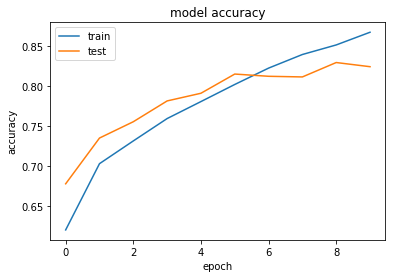

In [6]:
model = build_CNN_model()
history = train_model(model,'dogs_and_cats',10)
plt = get_plt(history)
plt.show()

La linea base para perros y gatos es del 50%, ya que se tienen la misma cantidad de imagenes para las dos clases. Los dataset de entrenamiento y prueba se encuentran estratificados.

Sobre el dataset de perros y gatos, en 10 epocas, se logra superar la linea base y alcanzar un accuracy de validación de 82,92%.

### Entrenar modelo con dataset de Leishmaniasis Cutanea

Despues de probar el modelo con perros y gatos se probará con leishmaniasis cutanea, para ver como desempeña y establecer un punto incial para resolver el problema. Cabe destacar que el tamaño de los datasets es diferente. El dataset de perros y gatos tiene 21500 de imagenes de entrenamiento, el de lishmaniasis cutanea tiene 1640 y está desbalanceado.

La linea base, dado el número de imagenes negativas y positivas, es del 76%. Si el modelo predice que todas son leishmaniasis, se obtendrá accuracy de 76%.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 220, 220, 32)      4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 106, 106, 128)     73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 53, 53, 128)       0         
__________

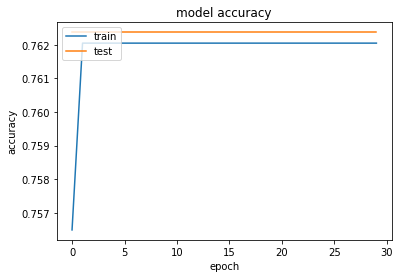

In [7]:
model = build_CNN_model()
history = train_model(model,'leishmaniasis',30)
plt = get_plt(history)
plt.show()

Del entrenamiento anterior se observa que no fue posible superar la linea base, tanto para el entrenamiento como para la validación. Esto presenta problemas dado que el accuracy de entrenamiento deberia de incrementar y ajustarse totalmente a los datos de entrenamiento, generado un estado de overfitting. 

Se procede a redefinir la función de entrenamiento con el fin de conseguir que el modelo aprenda correctamente las caracteristicas del conjunto de entrenamiento, y entré en overfitting. 

In [3]:
# model: model to be trained
# dataset: leishmaniasis, melanoma_novus, cats_and_dogs
# epochs: number of ephocs for training
# save_as: name to save best weigths
def train_model(model,dataset,epochs,image_size=224,batch_size=64,save_as='no_save'):
    # Data generator to  rescale training images
    # Data Augmentation: Horizontal and vertical flips
    train_datagen = ImageDataGenerator(rescale=1./255.0,
                                      vertical_flip=True,
                                      horizontal_flip=True)
    # Data generator to rescale test images
    test_datagen = ImageDataGenerator(rescale=1./255.0)
    # Data flow training images
    train_flow = train_datagen.flow_from_directory(
        directory='src/'+dataset+'/training',  
        target_size=(image_size, image_size),  
        batch_size=batch_size,
        class_mode='binary')
    # Data flow test images
    test_flow = test_datagen.flow_from_directory(
        directory='src/'+dataset+'/test',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary')
    # Compile model
    adam = optimizers.Adam(lr=0.0001,
                          beta_1=0.9,
                          beta_2=0.999,
                          epsilon=None,
                          decay=0.00001,
                          amsgrad=False)
    model.compile(
        loss='binary_crossentropy',
        optimizer=adam,
        metrics=['acc'])
    # Check if wegths are gona be saved
    if( save_as != 'no_save'):
        # Create check point call back to store best validation weigths
        bestWeigthsPath='src/trainingWeigths/best_' + save_as+'.h5'
        checkpoint = ModelCheckpoint(bestWeigthsPath, monitor='val_acc',save_weights_only=False, verbose=1, save_best_only=True, mode='max')
        # Run experiment
        history = model.fit_generator(
            generator=train_flow,
            epochs=epochs,
            validation_data=test_flow,
            callbacks=[checkpoint],
            verbose=1)
    else:
        # Run experiment
        history = model.fit_generator(
            generator=train_flow,
            epochs=epochs,
            validation_data=test_flow,
            verbose=1)
    return history

Se cambió el optimizador. Se utilizó un learning rate 10 veces menor que el utilizado en el problema de perros y gatos. Además, se definió decay= 0.00001, por lo que el learning rate disminuye a medida que corren las epocas. Se optó por esta decisión dado que es posible que al tener un learning rate alto, sin decay, no sea posible llegar a un minimo local, sino que se tienen saltos grandes.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 220, 220, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 106, 106, 128)     73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 53, 53, 128)       0         
__________

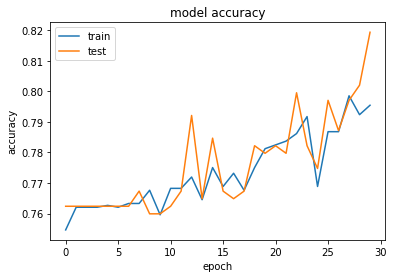

In [10]:
model = build_CNN_model()
history = train_model(model,'leishmaniasis',30)
plt = get_plt(history)
plt.show()

Comprobamos que al cambiar el learning rate es posible salir de la linea base, ahora se correran 100 épocas, con el fin de ver en que momento se entra en overfitting, y que valor máximo de accuracy de validación se puede obtener.

### primer intento

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 220, 220, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 106, 106, 128)     73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 53, 53, 128)       0         
__________

26/26 [==============================] - 31s 1s/step - loss: 0.2047 - acc: 0.9063 - val_loss: 0.5716 - val_acc: 0.7921

Epoch 00077: val_acc did not improve from 0.80693
Epoch 78/150
26/26 [==============================] - 31s 1s/step - loss: 0.1825 - acc: 0.9168 - val_loss: 0.6707 - val_acc: 0.7871

Epoch 00078: val_acc did not improve from 0.80693
Epoch 79/150
26/26 [==============================] - 31s 1s/step - loss: 0.1781 - acc: 0.9152 - val_loss: 0.6301 - val_acc: 0.7921

Epoch 00079: val_acc did not improve from 0.80693
Epoch 80/150
26/26 [==============================] - 31s 1s/step - loss: 0.1757 - acc: 0.9170 - val_loss: 0.6000 - val_acc: 0.7847

Epoch 00080: val_acc did not improve from 0.80693
Epoch 81/150
26/26 [==============================] - 32s 1s/step - loss: 0.1780 - acc: 0.9110 - val_loss: 0.5639 - val_acc: 0.8020

Epoch 00081: val_acc did not improve from 0.80693
Epoch 82/150
26/26 [==============================] - 31s 1s/step - loss: 0.1806 - acc: 0.9131 - v


Epoch 00121: val_acc did not improve from 0.80693
Epoch 122/150
26/26 [==============================] - 31s 1s/step - loss: 0.0970 - acc: 0.9570 - val_loss: 0.8132 - val_acc: 0.7822

Epoch 00122: val_acc did not improve from 0.80693
Epoch 123/150
26/26 [==============================] - 30s 1s/step - loss: 0.0912 - acc: 0.9567 - val_loss: 0.8340 - val_acc: 0.7896

Epoch 00123: val_acc did not improve from 0.80693
Epoch 124/150
26/26 [==============================] - 31s 1s/step - loss: 0.0903 - acc: 0.9639 - val_loss: 0.8985 - val_acc: 0.7896

Epoch 00124: val_acc did not improve from 0.80693
Epoch 125/150
26/26 [==============================] - 32s 1s/step - loss: 0.0920 - acc: 0.9640 - val_loss: 0.8120 - val_acc: 0.7946

Epoch 00125: val_acc did not improve from 0.80693
Epoch 126/150
26/26 [==============================] - 32s 1s/step - loss: 0.1158 - acc: 0.9501 - val_loss: 0.8421 - val_acc: 0.7871

Epoch 00126: val_acc did not improve from 0.80693
Epoch 127/150
26/26 [========

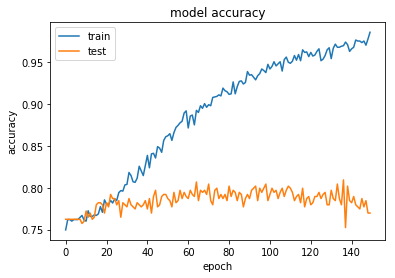

In [21]:
model = build_CNN_model()
history = train_model(model,'leishmaniasis',150,save_as='first_try')
export(model,'first_try')
plt = get_plt(history)
plt.show()

De lo anterior se observa que la máxima exactitud que se obtuvo es de 80.9%. Tambien se observa que el modelo entra en sobre ajuste. Al entrar en sobre ajuste, las caracteristicas que guarda el modelo pueden estar demasiado ajustadas al conjunto de entrenamiento. 

### Regularización de kernel y bias

Para combatir el sobre ajuste,  se agregará regularización l2 de kernel y bias, y se agrega una capa extra de dropout. Se procede a ejecutar 150 epocas para ver si esta medida es efectiva.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 220, 220, 32)      4640      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 106, 106, 128)     73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 53, 53, 128)       0         
__________

26/26 [==============================] - 30s 1s/step - loss: 0.6287 - acc: 0.8087 - val_loss: 0.7216 - val_acc: 0.7748

Epoch 00076: val_acc did not improve from 0.79208
Epoch 77/150
26/26 [==============================] - 31s 1s/step - loss: 0.6230 - acc: 0.8115 - val_loss: 0.7236 - val_acc: 0.7772

Epoch 00077: val_acc did not improve from 0.79208
Epoch 78/150
26/26 [==============================] - 30s 1s/step - loss: 0.6149 - acc: 0.8075 - val_loss: 0.7406 - val_acc: 0.7822

Epoch 00078: val_acc did not improve from 0.79208
Epoch 79/150
26/26 [==============================] - 30s 1s/step - loss: 0.6053 - acc: 0.8151 - val_loss: 0.7489 - val_acc: 0.7797

Epoch 00079: val_acc did not improve from 0.79208
Epoch 80/150
26/26 [==============================] - 31s 1s/step - loss: 0.6070 - acc: 0.8140 - val_loss: 0.7174 - val_acc: 0.7772

Epoch 00080: val_acc did not improve from 0.79208
Epoch 81/150
26/26 [==============================] - 30s 1s/step - loss: 0.6096 - acc: 0.8050 - v

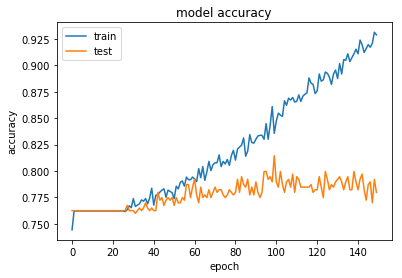

In [22]:
# Load custom model
def build_CNN_model(image_size=224):
    #Input
    inputs = Input(shape=(image_size,image_size,3,))
    #BranchOne
    model = Conv2D(filters=16,kernel_size=(3,3),activation='relu',
                   kernel_regularizer=regularizers.l2(0.01),bias_regularizer=regularizers.l2(0.01))(inputs)
    model = Conv2D(filters=32,kernel_size=(3,3),activation='relu',
                   kernel_regularizer=regularizers.l2(0.01),bias_regularizer=regularizers.l2(0.01))(model)
    model = MaxPooling2D(pool_size=(2,2))(model)    
    model = Conv2D(filters=64,kernel_size=(3,3),activation='relu',
                   kernel_regularizer=regularizers.l2(0.01),bias_regularizer=regularizers.l2(0.01))(model) 
    model = Conv2D(filters=128,kernel_size=(3,3),activation='relu',
                   kernel_regularizer=regularizers.l2(0.01),bias_regularizer=regularizers.l2(0.01))(model)
    model = MaxPooling2D(pool_size=(2,2))(model)
    model = Flatten()(model)
    model = Dropout(0.2)(model)
    model = Dense(124,activation='relu')(model)
    model = Dropout(0.5)(model)
    #Output
    out = Dense(1, activation='sigmoid')(model)
    # Compile Model
    model = Model(inputs=[inputs], outputs=[out])
    model.summary()
    model = multi_gpu_model(model, gpus=2)
    return model

model = build_CNN_model()
history = train_model(model,'leishmaniasis',150,save_as='second_try')
export(model,'second_try')
plt = get_plt(history)
plt.show()

Al probar regularización de kernel y bias se obtienen mejores, aunque el modelo sigue en sobreajuste. 

Para mejorar los resultados, se intentará utilizar redes convolucionales ya creadas y entrenadas para identificar caracteristicas de las imagenes. El objetivo es reutilizar los filtros que se han entrenado a partir de datasets más diversos y más grandes en el contexto del problema actual; y ver si al reutilizar estos filtros se obtienen mejores resultados.

# Transfer learning

### Definición de función para crear modelo

Primero, se crea una función que reciba capas convolucionales, las congele todas y agregue capas de clasificación al final. Se imprimirá la información de cada capa y se correrá en dos GPU.

In [14]:
# Builds model for transfer learning and fine tunning
def build_transfer_learning_model(conv_layers):
    # Freeze conv layers that are not going to be trained
    for layer in conv_layers.layers[:]:
        layer.trainable = False 
    # Print summary of the layers
    for layer in conv_layers.layers:
        print(layer, layer.trainable)    
    # Create sequential model
    model = Sequential()
    # add conv layers to model
    model.add(conv_layers)
    # Add clasification layers to model
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model = multi_gpu_model(model, gpus=2)
    model.summary()
    return model  

Se intentará realizar el entrenamiento con cuatro redes convolucionales creadas de keras applications. Se cargaran los pesos de image net. No se incluirá la parte de clasificación de estas redes.

### VGG16

In [26]:
image_size=224

58892288/58889256 [==============================] - 215s 4us/step
<keras.engine.input_layer.InputLayer object at 0x7efd7e8e7278> False
<keras.layers.convolutional.Conv2D object at 0x7efd84102f28> False
<keras.layers.convolutional.Conv2D object at 0x7efd7ed12780> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd8415ed30> False
<keras.layers.convolutional.Conv2D object at 0x7efd7ed02438> False
<keras.layers.convolutional.Conv2D object at 0x7efd7e8a2550> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd7e807860> False
<keras.layers.convolutional.Conv2D object at 0x7efd7e8167f0> False
<keras.layers.convolutional.Conv2D object at 0x7efd7e830978> False
<keras.layers.convolutional.Conv2D object at 0x7efd7dedab38> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd7dec5d30> False
<keras.layers.convolutional.Conv2D object at 0x7efd7deef550> False
<keras.layers.convolutional.Conv2D object at 0x7efd7de9c358> False
<keras.layers.convolutional.Conv2D object at 0x7efd7de9cf98>

26/26 [==============================] - 30s 1s/step - loss: 0.1620 - acc: 0.9501 - val_loss: 0.3563 - val_acc: 0.8639

Epoch 00068: val_acc did not improve from 0.86881
Epoch 69/150
26/26 [==============================] - 30s 1s/step - loss: 0.1665 - acc: 0.9399 - val_loss: 0.3434 - val_acc: 0.8589

Epoch 00069: val_acc did not improve from 0.86881
Epoch 70/150
26/26 [==============================] - 31s 1s/step - loss: 0.1721 - acc: 0.9356 - val_loss: 0.4049 - val_acc: 0.8317

Epoch 00070: val_acc did not improve from 0.86881
Epoch 71/150
26/26 [==============================] - 31s 1s/step - loss: 0.1716 - acc: 0.9339 - val_loss: 0.3482 - val_acc: 0.8589

Epoch 00071: val_acc did not improve from 0.86881
Epoch 72/150
26/26 [==============================] - 30s 1s/step - loss: 0.1649 - acc: 0.9428 - val_loss: 0.3498 - val_acc: 0.8540

Epoch 00072: val_acc did not improve from 0.86881
Epoch 73/150
26/26 [==============================] - 31s 1s/step - loss: 0.1583 - acc: 0.9416 - v

26/26 [==============================] - 30s 1s/step - loss: 0.0980 - acc: 0.9714 - val_loss: 0.3809 - val_acc: 0.8639

Epoch 00112: val_acc did not improve from 0.87376
Epoch 113/150
26/26 [==============================] - 31s 1s/step - loss: 0.0968 - acc: 0.9684 - val_loss: 0.3404 - val_acc: 0.8713

Epoch 00113: val_acc did not improve from 0.87376
Epoch 114/150
26/26 [==============================] - 31s 1s/step - loss: 0.1100 - acc: 0.9654 - val_loss: 0.3797 - val_acc: 0.8614

Epoch 00114: val_acc did not improve from 0.87376
Epoch 115/150
26/26 [==============================] - 30s 1s/step - loss: 0.1080 - acc: 0.9639 - val_loss: 0.3427 - val_acc: 0.8688

Epoch 00115: val_acc did not improve from 0.87376
Epoch 116/150
26/26 [==============================] - 30s 1s/step - loss: 0.0927 - acc: 0.9769 - val_loss: 0.3537 - val_acc: 0.8589

Epoch 00116: val_acc did not improve from 0.87376
Epoch 117/150
26/26 [==============================] - 30s 1s/step - loss: 0.0910 - acc: 0.974

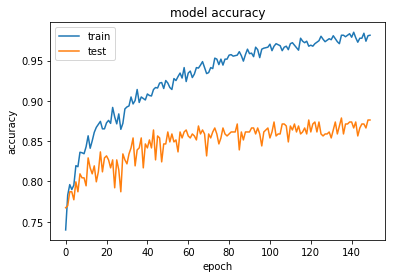

In [27]:
conv_layers = VGG16(weights='imagenet',include_top=False,input_shape=(image_size, image_size, 3))
model = build_transfer_learning_model(conv_layers)
history = train_model(model,'leishmaniasis',150,save_as='transfer_VGG16')
export(model, 'transfer_VGG16')
plt = get_plt(history)
plt.show()

### VGG19

80142336/80134624 [==============================] - 343s 4us/step
<keras.engine.input_layer.InputLayer object at 0x7efd7e8e63c8> False
<keras.layers.convolutional.Conv2D object at 0x7efd7cc23358> False
<keras.layers.convolutional.Conv2D object at 0x7efd8411f9e8> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd7e8e7128> False
<keras.layers.convolutional.Conv2D object at 0x7efd7cbc7588> False
<keras.layers.convolutional.Conv2D object at 0x7efd7cbf6828> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd7cb883c8> False
<keras.layers.convolutional.Conv2D object at 0x7efd7cb99710> False
<keras.layers.convolutional.Conv2D object at 0x7efd7cbb25f8> False
<keras.layers.convolutional.Conv2D object at 0x7efd7cb49e10> False
<keras.layers.convolutional.Conv2D object at 0x7efd7cb74828> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd7cb02ef0> False
<keras.layers.convolutional.Conv2D object at 0x7efd7cb1ee48> False
<keras.layers.convolutional.Conv2D object at 0x7efd7cac9a20>

Epoch 25/150
26/26 [==============================] - 30s 1s/step - loss: 0.3214 - acc: 0.8626 - val_loss: 0.3836 - val_acc: 0.8465

Epoch 00025: val_acc improved from 0.84158 to 0.84653, saving model to src/trainingWeigths/best_transfer_VGG19.hdf5
Epoch 26/150
26/26 [==============================] - 31s 1s/step - loss: 0.3278 - acc: 0.8628 - val_loss: 0.3703 - val_acc: 0.8193

Epoch 00026: val_acc did not improve from 0.84653
Epoch 27/150
26/26 [==============================] - 31s 1s/step - loss: 0.3072 - acc: 0.8764 - val_loss: 0.3687 - val_acc: 0.8564

Epoch 00027: val_acc improved from 0.84653 to 0.85644, saving model to src/trainingWeigths/best_transfer_VGG19.hdf5
Epoch 28/150
26/26 [==============================] - 30s 1s/step - loss: 0.3042 - acc: 0.8773 - val_loss: 0.3776 - val_acc: 0.8168

Epoch 00028: val_acc did not improve from 0.85644
Epoch 29/150
26/26 [==============================] - 30s 1s/step - loss: 0.2975 - acc: 0.8671 - val_loss: 0.3674 - val_acc: 0.8540

Epo


Epoch 00067: val_acc did not improve from 0.86139
Epoch 68/150
26/26 [==============================] - 30s 1s/step - loss: 0.2167 - acc: 0.9158 - val_loss: 0.3593 - val_acc: 0.8564

Epoch 00068: val_acc did not improve from 0.86139
Epoch 69/150
26/26 [==============================] - 31s 1s/step - loss: 0.2106 - acc: 0.9224 - val_loss: 0.3624 - val_acc: 0.8663

Epoch 00069: val_acc improved from 0.86139 to 0.86634, saving model to src/trainingWeigths/best_transfer_VGG19.hdf5
Epoch 70/150
26/26 [==============================] - 30s 1s/step - loss: 0.2073 - acc: 0.9249 - val_loss: 0.3840 - val_acc: 0.8465

Epoch 00070: val_acc did not improve from 0.86634
Epoch 71/150
26/26 [==============================] - 30s 1s/step - loss: 0.2349 - acc: 0.9047 - val_loss: 0.3563 - val_acc: 0.8540

Epoch 00071: val_acc did not improve from 0.86634
Epoch 72/150
26/26 [==============================] - 30s 1s/step - loss: 0.2140 - acc: 0.9074 - val_loss: 0.4100 - val_acc: 0.8366

Epoch 00072: val_a

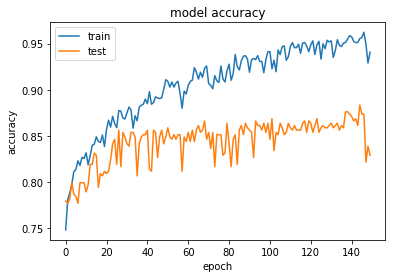

In [28]:
conv_layers = VGG19(weights='imagenet',include_top=False,input_shape=(image_size, image_size, 3))
model = build_transfer_learning_model(conv_layers)
history = train_model(model,'leishmaniasis',150,save_as='transfer_VGG19')
export(model, 'transfer_VGG19')
plt = get_plt(history)
plt.show()

### ResNet50

/home/icesi/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


<keras.engine.input_layer.InputLayer object at 0x7efd7efde940> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7efd7efdeba8> False
<keras.layers.convolutional.Conv2D object at 0x7efd7efdec88> False
<keras.layers.normalization.BatchNormalization object at 0x7efd840a2860> False
<keras.layers.core.Activation object at 0x7efd7efdedd8> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd7ed81dd8> False
<keras.layers.convolutional.Conv2D object at 0x7efd5fd96c18> False
<keras.layers.normalization.BatchNormalization object at 0x7efd5fd479b0> False
<keras.layers.core.Activation object at 0x7efd5fd36cf8> False
<keras.layers.convolutional.Conv2D object at 0x7efd5fcd35f8> False
<keras.layers.normalization.BatchNormalization object at 0x7efd5fca4780> False
<keras.layers.core.Activation object at 0x7efd5fca4828> False
<keras.layers.convolutional.Conv2D object at 0x7efd5fbc34e0> False
<keras.layers.convolutional.Conv2D object at 0x7efd5fb976a0> False
<keras.layers.normalization.Batc

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
resnet50_input (InputLayer)     (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_21 (Lambda)              (None, 224, 224, 3)  0           resnet50_input[0][0]             
__________________________________________________________________________________________________
lambda_22 (Lambda)              (None, 224, 224, 3)  0           resnet50_input[0][0]             
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 1)            49278337    lambda_21[0][0]                  
                                                                 lambda_22[0][0]                  
__________

26/26 [==============================] - 30s 1s/step - loss: 0.0033 - acc: 1.0000 - val_loss: 1.3976 - val_acc: 0.7624

Epoch 00080: val_acc did not improve from 0.76238
Epoch 81/150
26/26 [==============================] - 29s 1s/step - loss: 0.0050 - acc: 0.9988 - val_loss: 1.2183 - val_acc: 0.7624

Epoch 00081: val_acc did not improve from 0.76238
Epoch 82/150
26/26 [==============================] - 30s 1s/step - loss: 0.0043 - acc: 0.9982 - val_loss: 1.4057 - val_acc: 0.7624

Epoch 00082: val_acc did not improve from 0.76238
Epoch 83/150
26/26 [==============================] - 30s 1s/step - loss: 0.0021 - acc: 1.0000 - val_loss: 1.5250 - val_acc: 0.7624

Epoch 00083: val_acc did not improve from 0.76238
Epoch 84/150
26/26 [==============================] - 30s 1s/step - loss: 0.0046 - acc: 0.9979 - val_loss: 1.3941 - val_acc: 0.7624

Epoch 00084: val_acc did not improve from 0.76238
Epoch 85/150
26/26 [==============================] - 30s 1s/step - loss: 0.0040 - acc: 0.9994 - v


Epoch 00124: val_acc did not improve from 0.76238
Epoch 125/150
26/26 [==============================] - 30s 1s/step - loss: 0.0162 - acc: 0.9937 - val_loss: 1.0146 - val_acc: 0.7624

Epoch 00125: val_acc did not improve from 0.76238
Epoch 126/150
26/26 [==============================] - 30s 1s/step - loss: 0.0067 - acc: 0.9988 - val_loss: 1.0075 - val_acc: 0.7624

Epoch 00126: val_acc did not improve from 0.76238
Epoch 127/150
26/26 [==============================] - 31s 1s/step - loss: 0.0035 - acc: 0.9994 - val_loss: 1.0625 - val_acc: 0.7624

Epoch 00127: val_acc did not improve from 0.76238
Epoch 128/150
26/26 [==============================] - 29s 1s/step - loss: 0.0020 - acc: 0.9994 - val_loss: 0.9288 - val_acc: 0.7624

Epoch 00128: val_acc did not improve from 0.76238
Epoch 129/150
26/26 [==============================] - 29s 1s/step - loss: 0.0132 - acc: 0.9952 - val_loss: 0.9969 - val_acc: 0.7624

Epoch 00129: val_acc did not improve from 0.76238
Epoch 130/150
26/26 [========

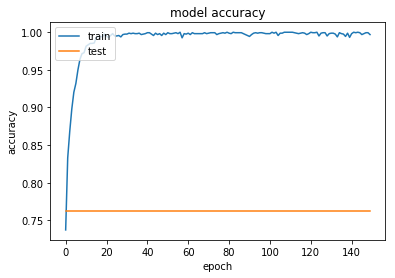

In [29]:
conv_layers = ResNet50(weights='imagenet',include_top=False,input_shape=(image_size, image_size, 3))
model = build_transfer_learning_model(conv_layers)
history = train_model(model,'leishmaniasis',150,save_as='transfer_ResNet50')
export(model, 'transfer_ResNet50')
plt = get_plt(history)
plt.show()

### InceptionV3

<keras.engine.input_layer.InputLayer object at 0x7f1106aff710> False
<keras.layers.convolutional.Conv2D object at 0x7f110b2146d8> False
<keras.layers.convolutional.Conv2D object at 0x7f1106aff048> False
<keras.layers.pooling.MaxPooling2D object at 0x7f110742b780> False
<keras.layers.convolutional.Conv2D object at 0x7f11073ea128> False
<keras.layers.convolutional.Conv2D object at 0x7f1106b59358> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1106b55278> False
<keras.layers.convolutional.Conv2D object at 0x7f1106b4a048> False
<keras.layers.convolutional.Conv2D object at 0x7f1107b61d68> False
<keras.layers.convolutional.Conv2D object at 0x7f1106ba36a0> False
<keras.layers.convolutional.Conv2D object at 0x7f1107e47be0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1107e4e8d0> False
<keras.layers.convolutional.Conv2D object at 0x7f1107e4b9b0> False
<keras.layers.convolutional.Conv2D object at 0x7f1106b31f28> False
<keras.layers.convolutional.Conv2D object at 0x7f1107327d68>

26/26 [==============================] - 33s 1s/step - loss: 0.4219 - acc: 0.8058 - val_loss: 0.4402 - val_acc: 0.7896

Epoch 00026: val_acc did not improve from 0.80941
Epoch 27/150
26/26 [==============================] - 34s 1s/step - loss: 0.4157 - acc: 0.8009 - val_loss: 0.4394 - val_acc: 0.7946

Epoch 00027: val_acc did not improve from 0.80941
Epoch 28/150
26/26 [==============================] - 33s 1s/step - loss: 0.4268 - acc: 0.7862 - val_loss: 0.4361 - val_acc: 0.7995

Epoch 00028: val_acc did not improve from 0.80941
Epoch 29/150
26/26 [==============================] - 33s 1s/step - loss: 0.4193 - acc: 0.8003 - val_loss: 0.4401 - val_acc: 0.7921

Epoch 00029: val_acc did not improve from 0.80941
Epoch 30/150
26/26 [==============================] - 34s 1s/step - loss: 0.4052 - acc: 0.8118 - val_loss: 0.4322 - val_acc: 0.7995

Epoch 00030: val_acc did not improve from 0.80941
Epoch 31/150
26/26 [==============================] - 33s 1s/step - loss: 0.4175 - acc: 0.7988 - v

26/26 [==============================] - 33s 1s/step - loss: 0.3611 - acc: 0.8382 - val_loss: 0.4404 - val_acc: 0.8045

Epoch 00113: val_acc did not improve from 0.83416
Epoch 114/150
26/26 [==============================] - 32s 1s/step - loss: 0.3701 - acc: 0.8162 - val_loss: 0.4328 - val_acc: 0.8094

Epoch 00114: val_acc did not improve from 0.83416
Epoch 115/150
26/26 [==============================] - 33s 1s/step - loss: 0.3479 - acc: 0.8427 - val_loss: 0.4254 - val_acc: 0.8069

Epoch 00115: val_acc did not improve from 0.83416
Epoch 116/150
26/26 [==============================] - 32s 1s/step - loss: 0.3503 - acc: 0.8347 - val_loss: 0.4336 - val_acc: 0.8168

Epoch 00116: val_acc did not improve from 0.83416
Epoch 117/150
26/26 [==============================] - 32s 1s/step - loss: 0.3498 - acc: 0.8389 - val_loss: 0.4227 - val_acc: 0.8144

Epoch 00117: val_acc did not improve from 0.83416
Epoch 118/150
26/26 [==============================] - 31s 1s/step - loss: 0.3585 - acc: 0.834

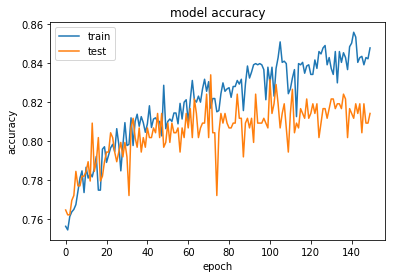

In [44]:
model = build_transfer_learning_model(conv_layers)
history = train_model(model,'leishmaniasis',150,save_as='transfer_InceptionV3')
plt = get_plt(history)
plt.show()

# Fine Tuning

A continuación se intentará realizar fine tuning con VGG19, que fue la red que mejor desempeñó en la predicción. Para esto se defina la función de construcción de modelo de fine tuning, congelando todas las capas menos las ultimas 5 (4 capas convolucionales).

In [6]:
# Builds model for transfer learning and fine tunning
def build_fine_tuning_model(conv_layers):
    # Freeze conv layers that are not going to be trained
    for layer in conv_layers.layers[:-5]:
        layer.trainable = False 
    # Print summary of the layers
    for layer in conv_layers.layers:
        print(layer, layer.trainable)    
    # Create sequential model
    model = Sequential()
    # add conv layers to model
    model.add(conv_layers)
    # Add clasification layers to model
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model = multi_gpu_model(model, gpus=2)
    model.summary()
    return model  

### Exportar historia

A partir de este punto se exportan las historias para su posterior 
analisis.

In [5]:
def export_history(history, save_as,epochs):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    file = open('src/history/history' + save_as+'.txt','w')
    file.write('acc,val_acc'+'\n')
    for i in range(epochs):
        file.write(str(acc[i])+','+str(val_acc[i])+'\n')
    file.close() 

### VGG19

<keras.engine.input_layer.InputLayer object at 0x7f10fcdac3c8> False
<keras.layers.convolutional.Conv2D object at 0x7f10fcdac1d0> False
<keras.layers.convolutional.Conv2D object at 0x7f10fde56d68> False
<keras.layers.pooling.MaxPooling2D object at 0x7f10fd61b6a0> False
<keras.layers.convolutional.Conv2D object at 0x7f10fddde7b8> False
<keras.layers.convolutional.Conv2D object at 0x7f10fcd43f60> False
<keras.layers.pooling.MaxPooling2D object at 0x7f10fd5c1e10> False
<keras.layers.convolutional.Conv2D object at 0x7f10fd5d6da0> False
<keras.layers.convolutional.Conv2D object at 0x7f10fd5fb518> False
<keras.layers.convolutional.Conv2D object at 0x7f10fd5954a8> False
<keras.layers.convolutional.Conv2D object at 0x7f10fd5a9e80> False
<keras.layers.pooling.MaxPooling2D object at 0x7f10fd554898> False
<keras.layers.convolutional.Conv2D object at 0x7f10fd565828> False
<keras.layers.convolutional.Conv2D object at 0x7f10fd57d940> False
<keras.layers.convolutional.Conv2D object at 0x7f10fd516f28>

26/26 [==============================] - 32s 1s/step - loss: 0.0096 - acc: 0.9946 - val_loss: 0.5354 - val_acc: 0.9257

Epoch 00067: val_acc improved from 0.91584 to 0.92574, saving model to src/trainingWeigths/best_fine_tuning_VGG19.h5
Epoch 68/150
26/26 [==============================] - 31s 1s/step - loss: 0.0097 - acc: 0.9952 - val_loss: 0.6772 - val_acc: 0.9233

Epoch 00068: val_acc did not improve from 0.92574
Epoch 69/150
26/26 [==============================] - 31s 1s/step - loss: 0.0116 - acc: 0.9970 - val_loss: 0.7272 - val_acc: 0.8886

Epoch 00069: val_acc did not improve from 0.92574
Epoch 70/150
26/26 [==============================] - 32s 1s/step - loss: 0.0233 - acc: 0.9892 - val_loss: 0.4599 - val_acc: 0.9134

Epoch 00070: val_acc did not improve from 0.92574
Epoch 71/150
26/26 [==============================] - 32s 1s/step - loss: 0.0121 - acc: 0.9940 - val_loss: 0.7607 - val_acc: 0.8886

Epoch 00071: val_acc did not improve from 0.92574
Epoch 72/150
26/26 [===========

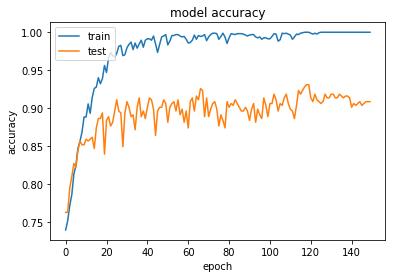

In [47]:
epochs = 150
save_as = 'fine_tuning_VGG19'
# Train model
conv_layers = VGG19(weights='imagenet',include_top=False,input_shape=(224, 224, 3))
model = build_fine_tuning_model(conv_layers)
history = train_model(model,'leishmaniasis',epochs,save_as=save_as)
# Export history
export_history(history, save_as,epochs)
# Plot accuracy
plt = get_plt(history)
plt.show()

### VGG19 Sequential API para erxportar a Android

In [16]:
from keras.utils import get_file 

# Builds model for transfer learning and fine tunning
def build_VGG19_fine_tuning_model(last_trainable_layers):
    model = Sequential()
    # block 1
    model.add(Conv2D(64, (3, 3),activation='relu',padding='same',name='block1_conv1',input_shape=(224,224,3)))
    model.add(Conv2D(64, (3, 3),activation='relu',padding='same',name='block1_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))
    # Block 2
    model.add(Conv2D(128, (3, 3),activation='relu',padding='same',name='block2_conv1'))
    model.add(Conv2D(128, (3, 3),activation='relu',padding='same',name='block2_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))
    # Block 3
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv1'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv2'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv3'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))
    # Block 4
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv1'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv2'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv3'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))
    # Block 5
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv1'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv2'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv3'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))
    weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        cache_subdir='models',
                        file_hash='253f8cb515780f3b799900260a226db6')
    model.load_weights(weights_path)
    # Freeze conv layers that are not going to be trained
    for layer in model.layers[:-last_trainable_layers]:
        layer.trainable = False 
    # Print summary of the layers
    for layer in model.layers:
        print(layer, layer.trainable)  
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1,activation='sigmoid'))    
    model.summary()
    return model  

<keras.layers.convolutional.Conv2D object at 0x7fc8cc121d30> False
<keras.layers.convolutional.Conv2D object at 0x7fc8cc121a90> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc8ee1a00b8> False
<keras.layers.convolutional.Conv2D object at 0x7fc8cc1731d0> False
<keras.layers.convolutional.Conv2D object at 0x7fc8effefbe0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc8effd1b70> False
<keras.layers.convolutional.Conv2D object at 0x7fc8effdab00> False
<keras.layers.convolutional.Conv2D object at 0x7fc8eff8b358> False
<keras.layers.convolutional.Conv2D object at 0x7fc8eff8bef0> False
<keras.layers.convolutional.Conv2D object at 0x7fc8effb6c18> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc8eff62630> False
<keras.layers.convolutional.Conv2D object at 0x7fc8eff714a8> False
<keras.layers.convolutional.Conv2D object at 0x7fc8eff0ad30> False
<keras.layers.convolutional.Conv2D object at 0x7fc8eff1ecc0> False
<keras.layers.convolutional.Conv2D object at 0x7fc8efec66d8> F


Epoch 00067: val_acc did not improve from 0.92079
Epoch 68/150
26/26 [==============================] - 34s 1s/step - loss: 0.0333 - acc: 0.9868 - val_loss: 0.6475 - val_acc: 0.8837

Epoch 00068: val_acc did not improve from 0.92079
Epoch 69/150
26/26 [==============================] - 33s 1s/step - loss: 0.0186 - acc: 0.9934 - val_loss: 0.7426 - val_acc: 0.8738

Epoch 00069: val_acc did not improve from 0.92079
Epoch 70/150
26/26 [==============================] - 33s 1s/step - loss: 0.0816 - acc: 0.9687 - val_loss: 0.5435 - val_acc: 0.8936

Epoch 00070: val_acc did not improve from 0.92079
Epoch 71/150
26/26 [==============================] - 33s 1s/step - loss: 0.0507 - acc: 0.9856 - val_loss: 0.5558 - val_acc: 0.8812

Epoch 00071: val_acc did not improve from 0.92079
Epoch 72/150
26/26 [==============================] - 32s 1s/step - loss: 0.0187 - acc: 0.9928 - val_loss: 0.5236 - val_acc: 0.8936

Epoch 00072: val_acc did not improve from 0.92079
Epoch 73/150
26/26 [==============


Epoch 00111: val_acc did not improve from 0.92574
Epoch 112/150
26/26 [==============================] - 33s 1s/step - loss: 0.0206 - acc: 0.9964 - val_loss: 0.6073 - val_acc: 0.8861

Epoch 00112: val_acc did not improve from 0.92574
Epoch 113/150
26/26 [==============================] - 33s 1s/step - loss: 0.0166 - acc: 0.9958 - val_loss: 0.6821 - val_acc: 0.8936

Epoch 00113: val_acc did not improve from 0.92574
Epoch 114/150
26/26 [==============================] - 33s 1s/step - loss: 0.0322 - acc: 0.9904 - val_loss: 0.5147 - val_acc: 0.8985

Epoch 00114: val_acc did not improve from 0.92574
Epoch 115/150
26/26 [==============================] - 34s 1s/step - loss: 0.0138 - acc: 0.9964 - val_loss: 0.6350 - val_acc: 0.8911

Epoch 00115: val_acc did not improve from 0.92574
Epoch 116/150
26/26 [==============================] - 32s 1s/step - loss: 0.0093 - acc: 0.9970 - val_loss: 0.6267 - val_acc: 0.9035

Epoch 00116: val_acc did not improve from 0.92574
Epoch 117/150
26/26 [========

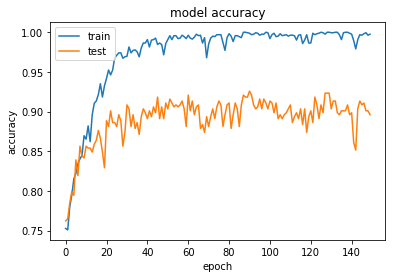

In [17]:
epochs = 150
save_as = 'fine_tuning_VGG19_5'
model = build_VGG19_fine_tuning_model(5)
history = train_model(model,'leishmaniasis',epochs,save_as=save_as)
# Export history
export_history(history, save_as,epochs)
# Plot accuracy
plt = get_plt(history)
plt.show()

### Evaluar especificidady sensibilidad

Procedemos a evaluar la sensibilidad y especirficidad del ultimo modelo entrenado.

In [3]:
from sklearn.metrics import classification_report
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

# Instanciate model
model = load_model('src/trainingWeigths/best_fine_tuning_VGG19_5.h5')
# Create data flow for test images
test_datagen = ImageDataGenerator(rescale=1./255.0)
generator = test_datagen.flow_from_directory(
        'src/leishmaniasis/test',
        target_size=(224, 224),
        batch_size=1,
        class_mode='binary',
        shuffle=False)  # keep data in same order as labels
y_true=[]
y_pred=[]
for i in range(404):
    x, y = generator.next()
    yz = model.predict(x)
    if(yz[0][0]<0.5):
        y_pred.append(0)
    else:
        y_pred.append(1)
    y_true.append(y[0])
print(classification_report(y_true,y_pred))

Found 404 images belonging to 2 classes.
             precision    recall  f1-score   support

        0.0       0.88      0.80      0.84        96
        1.0       0.94      0.96      0.95       308

avg / total       0.92      0.93      0.92       404



# Metricas para evaluaciòn de 100 imagenes (Comparaciòn con expertos)

Se realizo una prueba con 100 imagenes seleccionadas aleatoriamente del conjunto de prueba. A partir de estas 100 imagenes se espera comparar que tan bien desempeña el modelo en relación a expertos que realizan activamente diagnostico de leishmaniasis cutanea. El grupo de expertos esta compuesto por 5 medicos del cideim.

A continuación se carga el modelo con mayor exactitud hasta el momento (fine_tuning_vgg19) y se obtienen las metricas asociadas a las predicciones de este modelo.

### evaluar exactitud

In [4]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
# Instanciate model
model = load_model('src/trainingWeigths/best_fine_tuning_VGG19_5.h5')
# Create data flow for test images
test_datagen = ImageDataGenerator(rescale=1./255.0)
generator = test_datagen.flow_from_directory(
        'src/leishmaniasis_test',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary',
        shuffle=False)  # keep data in same order as labels
model.evaluate_generator(generator)

Found 100 images belonging to 2 classes.


[0.38378087258839516, 0.95]

In [5]:
model.metrics_names

['loss', 'acc']

### Evaluar sensibilidad y especificidad

In [6]:
from sklearn.metrics import classification_report
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

# Instanciate model
model = load_model('src/trainingWeigths/best_fine_tuning_VGG19_5.h5')
# Create data flow for test images
test_datagen = ImageDataGenerator(rescale=1./255.0)
generator = test_datagen.flow_from_directory(
        'src/leishmaniasis_test',
        target_size=(224, 224),
        batch_size=1,
        class_mode='binary',
        shuffle=False)  # keep data in same order as labels
y_true=[]
y_pred=[]
for i in range(100):
    x, y = generator.next()
    yz = model.predict(x)
    if(yz[0][0]<0.5):
        y_pred.append(0)
    else:
        y_pred.append(1)
    y_true.append(y[0])
print(classification_report(y_true,y_pred))

Found 100 images belonging to 2 classes.
             precision    recall  f1-score   support

        0.0       0.95      0.83      0.89        24
        1.0       0.95      0.99      0.97        76

avg / total       0.95      0.95      0.95       100



### Matriz de confusión

[[20  4]
 [ 1 75]]


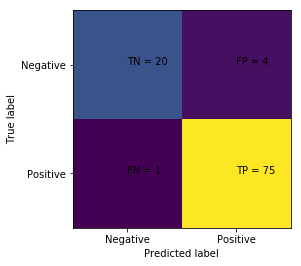

In [12]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_true,y_pred)
print(cm)

# Pretty print
plt.clf()
plt.imshow(cm, interpolation='nearest')
class_names  = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)
s = [['TN','FP'],['FN','TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(s[i][j])+ " = "+ str(cm[i][j]))
plt.show()

## Fine tuning + Regularización + Dropout

Con el fin de combatir el sobre ajuste que se ha presentado a lo large del experimento, se  agrega regularización l2 en la últimas capas convolucionales (las capas que se entrenarán), y se prueban diferentes valores de dropout con el fin de maximizar el error de validación.

primero, definimos una nueva función pra construir el modelo, recibiendo por parametro el valor de regularización y dropout, esto con el fin de tratar diferentes valores en un solo experimento.

**nota:** se entrenan las últimas cinco capas convolucionales dado que experimentos anteriores demuestran que es el nùmero adecuado de capas a entrenar para el problema en cuestión. 

### primer intento

In [34]:
# Builds model for transfer learning and fine tunning
#  PARAMS
#     dropout: dropout value for dropout layers
#     regularization: regularization 
def build_VGG19_fine_tuning_model(dropout, regularization):
    model = Sequential()
    # block 1
    model.add(Conv2D(64, (3, 3),activation='relu',padding='same',name='block1_conv1',input_shape=(224,224,3)))
    model.add(Conv2D(64, (3, 3),activation='relu',padding='same',name='block1_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))
    # Block 2
    model.add(Conv2D(128, (3, 3),activation='relu',padding='same',name='block2_conv1'))
    model.add(Conv2D(128, (3, 3),activation='relu',padding='same',name='block2_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))
    # Block 3
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv1'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv2'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv3'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))
    # Block 4
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv1'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv2'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv3'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))
    # Block 5
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv1',
                   kernel_regularizer=regularizers.l2(regularization),
                   bias_regularizer=regularizers.l2(regularization)))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv2',
                   kernel_regularizer=regularizers.l2(regularization),
                   bias_regularizer=regularizers.l2(regularization)))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv3',
                   kernel_regularizer=regularizers.l2(regularization),
                   bias_regularizer=regularizers.l2(regularization)))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv4',
                   kernel_regularizer=regularizers.l2(regularization),
                   bias_regularizer=regularizers.l2(regularization)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))
    weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        cache_subdir='models',
                        file_hash='253f8cb515780f3b799900260a226db6')
    model.load_weights(weights_path)
    # Freeze conv layers that are not going to be trained
    for layer in model.layers[:-5]:
        layer.trainable = False 
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='sigmoid'))    
    # Multigpu model to speed up
    model = multi_gpu_model(model, gpus=2)
    return model  


Segundo, definimos los diferentes niveles de regularización y dropout.

In [35]:
dropout = [0.1, 0.2, 0.3, 0.4, 0.5]
regularization = [0.001, 0.05, 0.01, 0.5, 0.1]

Tercero, deifnimos la función de entrenamiento.

In [36]:
# Function to train model
#     PARAMS:
#        optimizer: optimizer to train model
#        model: model to be trained
#        dataset: dataset to train modelo 
#        epoochs: number of epochs to train model
#        save_as: name to save best weigths
#     RETURNS
#        history: vaules for acc and val_acc for each epoch
def train_model(optimizer,model,dataset,epochs,save_as,image_size=224,batch_size=64):
    # Data generator to  rescale training images
    # Data Augmentation: Horizontal and vertical flips
    train_datagen = ImageDataGenerator(rescale=1./255.0,
                                      vertical_flip=True,
                                      horizontal_flip=True)
    # Data generator to rescale test images
    test_datagen = ImageDataGenerator(rescale=1./255.0)
    # Data flow training images
    train_flow = train_datagen.flow_from_directory(
        directory='src/'+dataset+'/training',  
        target_size=(image_size, image_size),  
        batch_size=batch_size,
        class_mode='binary')
    # Data flow test images
    test_flow = test_datagen.flow_from_directory(
        directory='src/'+dataset+'/test',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary')
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['acc'])
    # Create check point call back to store best validation weigths
    bestWeigthsPath='src/trainingWeigths/best_' + save_as+'.h5'
    checkpoint = ModelCheckpoint(bestWeigthsPath, monitor='val_acc',save_weights_only=False, verbose=1, save_best_only=True, mode='max')
    # Run experiment
    history = model.fit_generator(
            generator=train_flow,
            epochs=epochs,
            validation_data=test_flow,
            callbacks=[checkpoint],
            verbose=1)
    return history

Cuarto, definimos función para exportar historia de cada entrenamiento.

In [37]:
def export_history(history, save_as,epochs):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    file = open('src/history/history' + save_as+'.txt','w')
    file.write('acc,val_acc'+'\n')
    for i in range(epochs):
        file.write(str(acc[i])+','+str(val_acc[i])+'\n')
    file.close() 

Quinto, ejecutamos el experimento para cada combinación de dropout y regularización.

In [38]:
# create optimizer to train model
adam = optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.00001,amsgrad=False)
# create array to store experiment results
data = []
data.append(['dropout','regularization','val_acc'])
# run experiment
for _dropout in dropout:
    for _regularization in regularization:
        # Print level
        print('experiment: dropout='+str(_dropout)+' regularization'+str(_regularization))
        # build model
        model = build_VGG19_fine_tuning_model(_dropout, _regularization)
        # train model
        history = train_model(adam,model,'leishmaniasis',150,
                              save_as='finetuning_reg_drop_'+str(_dropout)+'_'+str(_regularization))
        # store result
        data.append([_dropout,_regularization,max(history.history['val_acc'])])
        # Export history
        export_history(history,'finetuning_reg_drop_'+str(_dropout)+'_'+str(_regularization),150)

experiment: dropout=0.1 regularization0.001
Found 1618 images belonging to 2 classes.
Found 404 images belonging to 2 classes.
Epoch 1/150
26/26 [==============================] - 27s 1s/step - loss: 1.3617 - acc: 0.7538 - val_loss: 1.2647 - val_acc: 0.7599

Epoch 00001: val_acc improved from -inf to 0.75990, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.1_0.001.h5
Epoch 2/150
26/26 [==============================] - 35s 1s/step - loss: 1.2210 - acc: 0.7625 - val_loss: 1.1465 - val_acc: 0.7748

Epoch 00002: val_acc improved from 0.75990 to 0.77475, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.1_0.001.h5
Epoch 3/150
26/26 [==============================] - 32s 1s/step - loss: 1.1094 - acc: 0.7811 - val_loss: 1.0638 - val_acc: 0.7970

Epoch 00003: val_acc improved from 0.77475 to 0.79703, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.1_0.001.h5
Epoch 4/150
26/26 [==============================] - 35s 1s/step - loss: 1.0193 - acc: 0.8046

Epoch 38/150
26/26 [==============================] - 35s 1s/step - loss: 0.3692 - acc: 0.9880 - val_loss: 0.8922 - val_acc: 0.8886

Epoch 00038: val_acc did not improve from 0.91089
Epoch 39/150
26/26 [==============================] - 36s 1s/step - loss: 0.3803 - acc: 0.9789 - val_loss: 0.7767 - val_acc: 0.9010

Epoch 00039: val_acc did not improve from 0.91089
Epoch 40/150
26/26 [==============================] - 35s 1s/step - loss: 0.3816 - acc: 0.9814 - val_loss: 0.8078 - val_acc: 0.8837

Epoch 00040: val_acc did not improve from 0.91089
Epoch 41/150
26/26 [==============================] - 35s 1s/step - loss: 0.3595 - acc: 0.9892 - val_loss: 0.7927 - val_acc: 0.8886

Epoch 00041: val_acc did not improve from 0.91089
Epoch 42/150
26/26 [==============================] - 36s 1s/step - loss: 0.4036 - acc: 0.9723 - val_loss: 0.7799 - val_acc: 0.8441

Epoch 00042: val_acc did not improve from 0.91089
Epoch 43/150
26/26 [==============================] - 34s 1s/step - loss: 0.3882 - ac

26/26 [==============================] - 36s 1s/step - loss: 0.2823 - acc: 0.9946 - val_loss: 0.8344 - val_acc: 0.9010

Epoch 00083: val_acc did not improve from 0.91089
Epoch 84/150
26/26 [==============================] - 35s 1s/step - loss: 0.2891 - acc: 0.9934 - val_loss: 0.8412 - val_acc: 0.8911

Epoch 00084: val_acc did not improve from 0.91089
Epoch 85/150
26/26 [==============================] - 35s 1s/step - loss: 0.2936 - acc: 0.9913 - val_loss: 0.7499 - val_acc: 0.8936

Epoch 00085: val_acc did not improve from 0.91089
Epoch 86/150
26/26 [==============================] - 35s 1s/step - loss: 0.2812 - acc: 0.9946 - val_loss: 0.7375 - val_acc: 0.8985

Epoch 00086: val_acc did not improve from 0.91089
Epoch 87/150
26/26 [==============================] - 36s 1s/step - loss: 0.2759 - acc: 0.9958 - val_loss: 0.8218 - val_acc: 0.8960

Epoch 00087: val_acc did not improve from 0.91089
Epoch 88/150
26/26 [==============================] - 35s 1s/step - loss: 0.2786 - acc: 0.9964 - v

26/26 [==============================] - 33s 1s/step - loss: 8.2728 - acc: 0.8049 - val_loss: 8.2230 - val_acc: 0.8069

Epoch 00017: val_acc improved from 0.80446 to 0.80693, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.1_0.05.h5
Epoch 18/150
26/26 [==============================] - 32s 1s/step - loss: 8.2014 - acc: 0.8060 - val_loss: 8.1590 - val_acc: 0.8020

Epoch 00018: val_acc did not improve from 0.80693
Epoch 19/150
26/26 [==============================] - 34s 1s/step - loss: 8.1357 - acc: 0.8097 - val_loss: 8.0991 - val_acc: 0.7995

Epoch 00019: val_acc did not improve from 0.80693
Epoch 20/150
26/26 [==============================] - 34s 1s/step - loss: 8.0835 - acc: 0.8022 - val_loss: 8.0637 - val_acc: 0.7822

Epoch 00020: val_acc did not improve from 0.80693
Epoch 21/150
26/26 [==============================] - 34s 1s/step - loss: 8.0196 - acc: 0.7965 - val_loss: 8.1089 - val_acc: 0.7847

Epoch 00021: val_acc did not improve from 0.80693
Epoch 22/150
26/26 [

26/26 [==============================] - 34s 1s/step - loss: 5.9101 - acc: 0.9414 - val_loss: 6.1158 - val_acc: 0.8490

Epoch 00102: val_acc did not improve from 0.86634
Epoch 103/150
26/26 [==============================] - 34s 1s/step - loss: 5.8947 - acc: 0.9435 - val_loss: 6.1487 - val_acc: 0.8515

Epoch 00103: val_acc did not improve from 0.86634
Epoch 104/150
26/26 [==============================] - 35s 1s/step - loss: 5.9064 - acc: 0.9282 - val_loss: 6.1466 - val_acc: 0.8292

Epoch 00104: val_acc did not improve from 0.86634
Epoch 105/150
26/26 [==============================] - 33s 1s/step - loss: 5.8777 - acc: 0.9368 - val_loss: 6.1099 - val_acc: 0.8639

Epoch 00105: val_acc did not improve from 0.86634
Epoch 106/150
26/26 [==============================] - 34s 1s/step - loss: 5.8683 - acc: 0.9329 - val_loss: 6.0764 - val_acc: 0.8540

Epoch 00106: val_acc did not improve from 0.86634
Epoch 107/150
26/26 [==============================] - 33s 1s/step - loss: 5.8667 - acc: 0.928

26/26 [==============================] - 36s 1s/step - loss: 5.4049 - acc: 0.9657 - val_loss: 5.7350 - val_acc: 0.8639

Epoch 00146: val_acc did not improve from 0.87129
Epoch 147/150
26/26 [==============================] - 34s 1s/step - loss: 5.3822 - acc: 0.9783 - val_loss: 5.7171 - val_acc: 0.8812

Epoch 00147: val_acc improved from 0.87129 to 0.88119, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.1_0.05.h5
Epoch 148/150
26/26 [==============================] - 36s 1s/step - loss: 5.4099 - acc: 0.9594 - val_loss: 5.7142 - val_acc: 0.8663

Epoch 00148: val_acc did not improve from 0.88119
Epoch 149/150
26/26 [==============================] - 35s 1s/step - loss: 5.3986 - acc: 0.9621 - val_loss: 5.7026 - val_acc: 0.8713

Epoch 00149: val_acc did not improve from 0.88119
Epoch 150/150
26/26 [==============================] - 35s 1s/step - loss: 5.3677 - acc: 0.9717 - val_loss: 5.7229 - val_acc: 0.8515

Epoch 00150: val_acc did not improve from 0.88119
experiment: drop


Epoch 00076: val_acc did not improve from 0.88366
Epoch 77/150
26/26 [==============================] - 37s 1s/step - loss: 1.4128 - acc: 0.9615 - val_loss: 1.7813 - val_acc: 0.8713

Epoch 00077: val_acc did not improve from 0.88366
Epoch 78/150
26/26 [==============================] - 34s 1s/step - loss: 1.4004 - acc: 0.9639 - val_loss: 1.8065 - val_acc: 0.8614

Epoch 00078: val_acc did not improve from 0.88366
Epoch 79/150
26/26 [==============================] - 35s 1s/step - loss: 1.3978 - acc: 0.9579 - val_loss: 1.8408 - val_acc: 0.8515

Epoch 00079: val_acc did not improve from 0.88366
Epoch 80/150
26/26 [==============================] - 36s 1s/step - loss: 1.3941 - acc: 0.9594 - val_loss: 1.7675 - val_acc: 0.8688

Epoch 00080: val_acc did not improve from 0.88366
Epoch 81/150
26/26 [==============================] - 36s 1s/step - loss: 1.3846 - acc: 0.9663 - val_loss: 1.8264 - val_acc: 0.8490

Epoch 00081: val_acc did not improve from 0.88366
Epoch 82/150
26/26 [==============


Epoch 00120: val_acc did not improve from 0.89851
Epoch 121/150
26/26 [==============================] - 36s 1s/step - loss: 1.2690 - acc: 0.9733 - val_loss: 1.7608 - val_acc: 0.8713

Epoch 00121: val_acc did not improve from 0.89851
Epoch 122/150
26/26 [==============================] - 36s 1s/step - loss: 1.2268 - acc: 0.9904 - val_loss: 1.8834 - val_acc: 0.8861

Epoch 00122: val_acc did not improve from 0.89851
Epoch 123/150
26/26 [==============================] - 36s 1s/step - loss: 1.2204 - acc: 0.9895 - val_loss: 1.7884 - val_acc: 0.8663

Epoch 00123: val_acc did not improve from 0.89851
Epoch 124/150
26/26 [==============================] - 36s 1s/step - loss: 1.2275 - acc: 0.9853 - val_loss: 1.7246 - val_acc: 0.8886

Epoch 00124: val_acc did not improve from 0.89851
Epoch 125/150
26/26 [==============================] - 35s 1s/step - loss: 1.2132 - acc: 0.9916 - val_loss: 1.8084 - val_acc: 0.8911

Epoch 00125: val_acc did not improve from 0.89851
Epoch 126/150
26/26 [========

26/26 [==============================] - 35s 1s/step - loss: 81.9580 - acc: 0.7595 - val_loss: 81.5405 - val_acc: 0.7624

Epoch 00013: val_acc did not improve from 0.76238
Epoch 14/150
26/26 [==============================] - 36s 1s/step - loss: 81.1979 - acc: 0.7566 - val_loss: 80.8112 - val_acc: 0.7624

Epoch 00014: val_acc did not improve from 0.76238
Epoch 15/150
26/26 [==============================] - 35s 1s/step - loss: 80.4831 - acc: 0.7625 - val_loss: 80.1271 - val_acc: 0.7624

Epoch 00015: val_acc did not improve from 0.76238
Epoch 16/150
26/26 [==============================] - 35s 1s/step - loss: 79.8152 - acc: 0.7625 - val_loss: 79.4807 - val_acc: 0.7624

Epoch 00016: val_acc did not improve from 0.76238
Epoch 17/150
26/26 [==============================] - 35s 1s/step - loss: 79.1829 - acc: 0.7654 - val_loss: 78.8635 - val_acc: 0.7624

Epoch 00017: val_acc did not improve from 0.76238
Epoch 18/150
26/26 [==============================] - 35s 1s/step - loss: 78.5858 - acc:

26/26 [==============================] - 35s 1s/step - loss: 58.2416 - acc: 0.7639 - val_loss: 58.1724 - val_acc: 0.7624

Epoch 00101: val_acc did not improve from 0.76238
Epoch 102/150
26/26 [==============================] - 35s 1s/step - loss: 58.1166 - acc: 0.7610 - val_loss: 58.0475 - val_acc: 0.7624

Epoch 00102: val_acc did not improve from 0.76238
Epoch 103/150
26/26 [==============================] - 35s 1s/step - loss: 57.9898 - acc: 0.7639 - val_loss: 57.9232 - val_acc: 0.7624

Epoch 00103: val_acc did not improve from 0.76238
Epoch 104/150
26/26 [==============================] - 35s 1s/step - loss: 57.8669 - acc: 0.7654 - val_loss: 57.8007 - val_acc: 0.7624

Epoch 00104: val_acc did not improve from 0.76238
Epoch 105/150
26/26 [==============================] - 35s 1s/step - loss: 57.7450 - acc: 0.7639 - val_loss: 57.6789 - val_acc: 0.7624

Epoch 00105: val_acc did not improve from 0.76238
Epoch 106/150
26/26 [==============================] - 35s 1s/step - loss: 57.6317 -

26/26 [==============================] - 35s 1s/step - loss: 14.6860 - acc: 0.8136 - val_loss: 14.6565 - val_acc: 0.8267

Epoch 00036: val_acc improved from 0.81683 to 0.82673, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.1_0.1.h5
Epoch 37/150
26/26 [==============================] - 35s 1s/step - loss: 14.6135 - acc: 0.8076 - val_loss: 14.5664 - val_acc: 0.8193

Epoch 00037: val_acc did not improve from 0.82673
Epoch 38/150
26/26 [==============================] - 35s 1s/step - loss: 14.5372 - acc: 0.8172 - val_loss: 14.5104 - val_acc: 0.8366

Epoch 00038: val_acc improved from 0.82673 to 0.83663, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.1_0.1.h5
Epoch 39/150
26/26 [==============================] - 34s 1s/step - loss: 14.4865 - acc: 0.8133 - val_loss: 14.4497 - val_acc: 0.8193

Epoch 00039: val_acc did not improve from 0.83663
Epoch 40/150
26/26 [==============================] - 35s 1s/step - loss: 14.4361 - acc: 0.8111 - val_loss: 14.3964 - v


Epoch 00078: val_acc did not improve from 0.85396
Epoch 79/150
26/26 [==============================] - 34s 1s/step - loss: 12.7097 - acc: 0.8476 - val_loss: 12.7152 - val_acc: 0.8342

Epoch 00079: val_acc did not improve from 0.85396
Epoch 80/150
26/26 [==============================] - 35s 1s/step - loss: 12.6900 - acc: 0.8383 - val_loss: 12.7117 - val_acc: 0.8317

Epoch 00080: val_acc did not improve from 0.85396
Epoch 81/150
26/26 [==============================] - 34s 1s/step - loss: 12.6578 - acc: 0.8430 - val_loss: 12.7327 - val_acc: 0.7871

Epoch 00081: val_acc did not improve from 0.85396
Epoch 82/150
26/26 [==============================] - 33s 1s/step - loss: 12.6454 - acc: 0.8368 - val_loss: 12.6334 - val_acc: 0.8366

Epoch 00082: val_acc did not improve from 0.85396
Epoch 83/150
26/26 [==============================] - 33s 1s/step - loss: 12.5816 - acc: 0.8512 - val_loss: 12.5940 - val_acc: 0.8490

Epoch 00083: val_acc did not improve from 0.85396
Epoch 84/150
26/26 [====

26/26 [==============================] - 33s 1s/step - loss: 11.6283 - acc: 0.8290 - val_loss: 11.5928 - val_acc: 0.8416

Epoch 00123: val_acc did not improve from 0.85396
Epoch 124/150
26/26 [==============================] - 34s 1s/step - loss: 11.5346 - acc: 0.8734 - val_loss: 11.5958 - val_acc: 0.8441

Epoch 00124: val_acc did not improve from 0.85396
Epoch 125/150
26/26 [==============================] - 32s 1s/step - loss: 11.5139 - acc: 0.8749 - val_loss: 11.5465 - val_acc: 0.8515

Epoch 00125: val_acc did not improve from 0.85396
Epoch 126/150
26/26 [==============================] - 34s 1s/step - loss: 11.4992 - acc: 0.8719 - val_loss: 11.5213 - val_acc: 0.8490

Epoch 00126: val_acc did not improve from 0.85396
Epoch 127/150
26/26 [==============================] - 34s 1s/step - loss: 11.4589 - acc: 0.8750 - val_loss: 11.5077 - val_acc: 0.8515

Epoch 00127: val_acc did not improve from 0.85396
Epoch 128/150
26/26 [==============================] - 33s 1s/step - loss: 11.4478 -

26/26 [==============================] - 32s 1s/step - loss: 0.6471 - acc: 0.8452 - val_loss: 0.7197 - val_acc: 0.8317

Epoch 00013: val_acc did not improve from 0.85644
Epoch 14/150
26/26 [==============================] - 34s 1s/step - loss: 0.6256 - acc: 0.8602 - val_loss: 0.6484 - val_acc: 0.8540

Epoch 00014: val_acc did not improve from 0.85644
Epoch 15/150
26/26 [==============================] - 34s 1s/step - loss: 0.6130 - acc: 0.8614 - val_loss: 0.6487 - val_acc: 0.8490

Epoch 00015: val_acc did not improve from 0.85644
Epoch 16/150
26/26 [==============================] - 33s 1s/step - loss: 0.5912 - acc: 0.8764 - val_loss: 0.6249 - val_acc: 0.8540

Epoch 00016: val_acc did not improve from 0.85644
Epoch 17/150
26/26 [==============================] - 33s 1s/step - loss: 0.6058 - acc: 0.8591 - val_loss: 0.6540 - val_acc: 0.8317

Epoch 00017: val_acc did not improve from 0.85644
Epoch 18/150
26/26 [==============================] - 33s 1s/step - loss: 0.5629 - acc: 0.8815 - v

26/26 [==============================] - 32s 1s/step - loss: 0.3122 - acc: 0.9633 - val_loss: 0.6363 - val_acc: 0.8787

Epoch 00054: val_acc did not improve from 0.89356
Epoch 55/150
26/26 [==============================] - 32s 1s/step - loss: 0.2954 - acc: 0.9705 - val_loss: 0.8393 - val_acc: 0.8663

Epoch 00055: val_acc did not improve from 0.89356
Epoch 56/150
26/26 [==============================] - 33s 1s/step - loss: 0.2903 - acc: 0.9714 - val_loss: 0.6676 - val_acc: 0.8936

Epoch 00056: val_acc did not improve from 0.89356
Epoch 57/150
26/26 [==============================] - 33s 1s/step - loss: 0.2623 - acc: 0.9862 - val_loss: 0.7290 - val_acc: 0.8960

Epoch 00057: val_acc improved from 0.89356 to 0.89604, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.2_0.001.h5
Epoch 58/150
26/26 [==============================] - 32s 1s/step - loss: 0.2551 - acc: 0.9868 - val_loss: 0.7826 - val_acc: 0.8960

Epoch 00058: val_acc improved from 0.89604 to 0.89604, saving model t


Epoch 00140: val_acc did not improve from 0.91584
Epoch 141/150
26/26 [==============================] - 33s 1s/step - loss: 0.1809 - acc: 0.9976 - val_loss: 0.8022 - val_acc: 0.9035

Epoch 00141: val_acc did not improve from 0.91584
Epoch 142/150
26/26 [==============================] - 34s 1s/step - loss: 0.1819 - acc: 0.9970 - val_loss: 0.7985 - val_acc: 0.9109

Epoch 00142: val_acc did not improve from 0.91584
Epoch 143/150
26/26 [==============================] - 32s 1s/step - loss: 0.1777 - acc: 1.0000 - val_loss: 0.8877 - val_acc: 0.9084

Epoch 00143: val_acc did not improve from 0.91584
Epoch 144/150
26/26 [==============================] - 33s 1s/step - loss: 0.1847 - acc: 0.9964 - val_loss: 0.9079 - val_acc: 0.8985

Epoch 00144: val_acc did not improve from 0.91584
Epoch 145/150
26/26 [==============================] - 31s 1s/step - loss: 0.1862 - acc: 0.9940 - val_loss: 0.9296 - val_acc: 0.8911

Epoch 00145: val_acc did not improve from 0.91584
Epoch 146/150
26/26 [========


Epoch 00030: val_acc did not improve from 0.83168
Epoch 31/150
26/26 [==============================] - 33s 1s/step - loss: 7.8662 - acc: 0.8271 - val_loss: 7.8458 - val_acc: 0.8342

Epoch 00031: val_acc improved from 0.83168 to 0.83416, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.2_0.05.h5
Epoch 32/150
26/26 [==============================] - 33s 1s/step - loss: 7.8347 - acc: 0.8190 - val_loss: 7.7975 - val_acc: 0.8366

Epoch 00032: val_acc improved from 0.83416 to 0.83663, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.2_0.05.h5
Epoch 33/150
26/26 [==============================] - 31s 1s/step - loss: 7.7720 - acc: 0.8410 - val_loss: 7.7541 - val_acc: 0.8366

Epoch 00033: val_acc did not improve from 0.83663
Epoch 34/150
26/26 [==============================] - 32s 1s/step - loss: 7.7420 - acc: 0.8319 - val_loss: 7.7569 - val_acc: 0.8267

Epoch 00034: val_acc did not improve from 0.83663
Epoch 35/150
26/26 [==============================] - 32s 1s/

26/26 [==============================] - 32s 1s/step - loss: 5.9998 - acc: 0.9468 - val_loss: 6.3067 - val_acc: 0.8589

Epoch 00117: val_acc did not improve from 0.86139
Epoch 118/150
26/26 [==============================] - 33s 1s/step - loss: 6.0023 - acc: 0.9492 - val_loss: 6.2650 - val_acc: 0.8465

Epoch 00118: val_acc did not improve from 0.86139
Epoch 119/150
26/26 [==============================] - 33s 1s/step - loss: 5.9674 - acc: 0.9639 - val_loss: 6.2610 - val_acc: 0.8614

Epoch 00119: val_acc did not improve from 0.86139
Epoch 120/150
26/26 [==============================] - 32s 1s/step - loss: 5.9874 - acc: 0.9411 - val_loss: 6.2719 - val_acc: 0.8391

Epoch 00120: val_acc did not improve from 0.86139
Epoch 121/150
26/26 [==============================] - 33s 1s/step - loss: 6.0238 - acc: 0.9233 - val_loss: 6.1993 - val_acc: 0.8391

Epoch 00121: val_acc did not improve from 0.86139
Epoch 122/150
26/26 [==============================] - 32s 1s/step - loss: 5.9684 - acc: 0.946

Epoch 8/150
26/26 [==============================] - 31s 1s/step - loss: 2.5015 - acc: 0.7925 - val_loss: 2.4407 - val_acc: 0.7995

Epoch 00008: val_acc improved from 0.77970 to 0.79950, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.2_0.01.h5
Epoch 9/150
26/26 [==============================] - 32s 1s/step - loss: 2.4328 - acc: 0.8040 - val_loss: 2.4017 - val_acc: 0.8168

Epoch 00009: val_acc improved from 0.79950 to 0.81683, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.2_0.01.h5
Epoch 10/150
26/26 [==============================] - 31s 1s/step - loss: 2.3664 - acc: 0.8139 - val_loss: 2.3469 - val_acc: 0.8168

Epoch 00010: val_acc did not improve from 0.81683
Epoch 11/150
26/26 [==============================] - 31s 1s/step - loss: 2.3187 - acc: 0.8136 - val_loss: 2.3063 - val_acc: 0.8218

Epoch 00011: val_acc improved from 0.81683 to 0.82178, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.2_0.01.h5
Epoch 12/150
26/26 [================


Epoch 00090: val_acc did not improve from 0.89356
Epoch 91/150
26/26 [==============================] - 32s 1s/step - loss: 1.3879 - acc: 0.9789 - val_loss: 1.8027 - val_acc: 0.8936

Epoch 00091: val_acc did not improve from 0.89356
Epoch 92/150
26/26 [==============================] - 32s 1s/step - loss: 1.3899 - acc: 0.9759 - val_loss: 1.7796 - val_acc: 0.8812

Epoch 00092: val_acc did not improve from 0.89356
Epoch 93/150
26/26 [==============================] - 33s 1s/step - loss: 1.3936 - acc: 0.9783 - val_loss: 1.9255 - val_acc: 0.8663

Epoch 00093: val_acc did not improve from 0.89356
Epoch 94/150
26/26 [==============================] - 32s 1s/step - loss: 1.4028 - acc: 0.9753 - val_loss: 1.8860 - val_acc: 0.8787

Epoch 00094: val_acc did not improve from 0.89356
Epoch 95/150
26/26 [==============================] - 32s 1s/step - loss: 1.3919 - acc: 0.9775 - val_loss: 1.9793 - val_acc: 0.8391

Epoch 00095: val_acc did not improve from 0.89356
Epoch 96/150
26/26 [==============

26/26 [==============================] - 33s 1s/step - loss: 76.9847 - acc: 0.7610 - val_loss: 76.7743 - val_acc: 0.7624

Epoch 00027: val_acc did not improve from 0.76238
Epoch 28/150
26/26 [==============================] - 32s 1s/step - loss: 76.5875 - acc: 0.7625 - val_loss: 76.3831 - val_acc: 0.7624

Epoch 00028: val_acc did not improve from 0.76238
Epoch 29/150
26/26 [==============================] - 33s 1s/step - loss: 76.2110 - acc: 0.7610 - val_loss: 76.0085 - val_acc: 0.7624

Epoch 00029: val_acc did not improve from 0.76238
Epoch 30/150
26/26 [==============================] - 33s 1s/step - loss: 75.8489 - acc: 0.7566 - val_loss: 75.6442 - val_acc: 0.7624

Epoch 00030: val_acc did not improve from 0.76238
Epoch 31/150
26/26 [==============================] - 32s 1s/step - loss: 75.4749 - acc: 0.7610 - val_loss: 75.2853 - val_acc: 0.7624

Epoch 00031: val_acc did not improve from 0.76238
Epoch 32/150
26/26 [==============================] - 32s 1s/step - loss: 75.1315 - acc:

26/26 [==============================] - 33s 1s/step - loss: 59.3435 - acc: 0.7625 - val_loss: 59.2799 - val_acc: 0.7624

Epoch 00115: val_acc did not improve from 0.76238
Epoch 116/150
26/26 [==============================] - 33s 1s/step - loss: 59.2278 - acc: 0.7625 - val_loss: 59.1654 - val_acc: 0.7624

Epoch 00116: val_acc did not improve from 0.76238
Epoch 117/150
26/26 [==============================] - 33s 1s/step - loss: 59.1151 - acc: 0.7654 - val_loss: 59.0524 - val_acc: 0.7624

Epoch 00117: val_acc did not improve from 0.76238
Epoch 118/150
26/26 [==============================] - 33s 1s/step - loss: 59.0075 - acc: 0.7610 - val_loss: 58.9400 - val_acc: 0.7624

Epoch 00118: val_acc did not improve from 0.76238
Epoch 119/150
26/26 [==============================] - 34s 1s/step - loss: 58.8973 - acc: 0.7566 - val_loss: 58.8281 - val_acc: 0.7624

Epoch 00119: val_acc did not improve from 0.76238
Epoch 120/150
26/26 [==============================] - 32s 1s/step - loss: 58.7854 -


Epoch 00047: val_acc did not improve from 0.83911
Epoch 48/150
26/26 [==============================] - 33s 1s/step - loss: 14.5605 - acc: 0.8067 - val_loss: 14.6064 - val_acc: 0.7599

Epoch 00048: val_acc did not improve from 0.83911
Epoch 49/150
26/26 [==============================] - 33s 1s/step - loss: 14.5005 - acc: 0.8187 - val_loss: 14.5080 - val_acc: 0.8144

Epoch 00049: val_acc did not improve from 0.83911
Epoch 50/150
26/26 [==============================] - 33s 1s/step - loss: 14.4394 - acc: 0.8268 - val_loss: 14.4295 - val_acc: 0.8292

Epoch 00050: val_acc did not improve from 0.83911
Epoch 51/150
26/26 [==============================] - 33s 1s/step - loss: 14.3873 - acc: 0.8344 - val_loss: 14.3727 - val_acc: 0.8317

Epoch 00051: val_acc did not improve from 0.83911
Epoch 52/150
26/26 [==============================] - 32s 1s/step - loss: 14.3426 - acc: 0.8319 - val_loss: 14.3353 - val_acc: 0.8366

Epoch 00052: val_acc did not improve from 0.83911
Epoch 53/150
26/26 [====

Epoch 91/150
26/26 [==============================] - 32s 1s/step - loss: 12.9084 - acc: 0.8548 - val_loss: 12.9306 - val_acc: 0.8416

Epoch 00091: val_acc did not improve from 0.84901
Epoch 92/150
26/26 [==============================] - 33s 1s/step - loss: 12.8740 - acc: 0.8596 - val_loss: 12.9353 - val_acc: 0.8168

Epoch 00092: val_acc did not improve from 0.84901
Epoch 93/150
26/26 [==============================] - 33s 1s/step - loss: 12.8395 - acc: 0.8633 - val_loss: 12.8935 - val_acc: 0.8366

Epoch 00093: val_acc did not improve from 0.84901
Epoch 94/150
26/26 [==============================] - 34s 1s/step - loss: 12.8281 - acc: 0.8440 - val_loss: 12.8618 - val_acc: 0.8342

Epoch 00094: val_acc did not improve from 0.84901
Epoch 95/150
26/26 [==============================] - 31s 1s/step - loss: 12.7720 - acc: 0.8728 - val_loss: 12.8066 - val_acc: 0.8342

Epoch 00095: val_acc did not improve from 0.84901
Epoch 96/150
26/26 [==============================] - 32s 1s/step - loss: 1

26/26 [==============================] - 33s 1s/step - loss: 0.5440 - acc: 0.8740 - val_loss: 0.6102 - val_acc: 0.8540

Epoch 00023: val_acc improved from 0.85396 to 0.85396, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.3_0.001.h5
Epoch 24/150
26/26 [==============================] - 33s 1s/step - loss: 0.4900 - acc: 0.9071 - val_loss: 0.6468 - val_acc: 0.8515

Epoch 00024: val_acc did not improve from 0.85396
Epoch 25/150
26/26 [==============================] - 33s 1s/step - loss: 0.4918 - acc: 0.8906 - val_loss: 0.6287 - val_acc: 0.8589

Epoch 00025: val_acc improved from 0.85396 to 0.85891, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.3_0.001.h5
Epoch 26/150
26/26 [==============================] - 32s 1s/step - loss: 0.4944 - acc: 0.8941 - val_loss: 0.6143 - val_acc: 0.8515

Epoch 00026: val_acc did not improve from 0.85891
Epoch 27/150
26/26 [==============================] - 33s 1s/step - loss: 0.4581 - acc: 0.9113 - val_loss: 0.6206 - val_acc

26/26 [==============================] - 33s 1s/step - loss: 0.2528 - acc: 0.9795 - val_loss: 0.7842 - val_acc: 0.8688

Epoch 00065: val_acc did not improve from 0.90347
Epoch 66/150
26/26 [==============================] - 33s 1s/step - loss: 0.2475 - acc: 0.9844 - val_loss: 0.8804 - val_acc: 0.8787

Epoch 00066: val_acc did not improve from 0.90347
Epoch 67/150
26/26 [==============================] - 33s 1s/step - loss: 0.2466 - acc: 0.9850 - val_loss: 0.9707 - val_acc: 0.8738

Epoch 00067: val_acc did not improve from 0.90347
Epoch 68/150
26/26 [==============================] - 33s 1s/step - loss: 0.2822 - acc: 0.9739 - val_loss: 0.7400 - val_acc: 0.8960

Epoch 00068: val_acc did not improve from 0.90347
Epoch 69/150
26/26 [==============================] - 32s 1s/step - loss: 0.2611 - acc: 0.9777 - val_loss: 0.7255 - val_acc: 0.8911

Epoch 00069: val_acc did not improve from 0.90347
Epoch 70/150
26/26 [==============================] - 34s 1s/step - loss: 0.2436 - acc: 0.9850 - v

26/26 [==============================] - 33s 1s/step - loss: 0.2095 - acc: 0.9910 - val_loss: 0.8086 - val_acc: 0.8960

Epoch 00109: val_acc did not improve from 0.91584
Epoch 110/150
26/26 [==============================] - 33s 1s/step - loss: 0.2156 - acc: 0.9898 - val_loss: 1.1178 - val_acc: 0.8738

Epoch 00110: val_acc did not improve from 0.91584
Epoch 111/150
26/26 [==============================] - 33s 1s/step - loss: 0.2031 - acc: 0.9952 - val_loss: 0.8514 - val_acc: 0.9059

Epoch 00111: val_acc did not improve from 0.91584
Epoch 112/150
26/26 [==============================] - 33s 1s/step - loss: 0.2102 - acc: 0.9934 - val_loss: 0.8573 - val_acc: 0.8837

Epoch 00112: val_acc did not improve from 0.91584
Epoch 113/150
26/26 [==============================] - 33s 1s/step - loss: 0.2169 - acc: 0.9850 - val_loss: 0.8687 - val_acc: 0.9035

Epoch 00113: val_acc did not improve from 0.91584
Epoch 114/150
26/26 [==============================] - 32s 1s/step - loss: 0.2111 - acc: 0.991


Epoch 00002: val_acc improved from 0.76238 to 0.76238, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.3_0.05.h5
Epoch 3/150
26/26 [==============================] - 32s 1s/step - loss: 11.5154 - acc: 0.7613 - val_loss: 10.9989 - val_acc: 0.7624

Epoch 00003: val_acc did not improve from 0.76238
Epoch 4/150
26/26 [==============================] - 34s 1s/step - loss: 10.7222 - acc: 0.7663 - val_loss: 10.4594 - val_acc: 0.7550

Epoch 00004: val_acc did not improve from 0.76238
Epoch 5/150
26/26 [==============================] - 33s 1s/step - loss: 10.2862 - acc: 0.7657 - val_loss: 10.0993 - val_acc: 0.7624

Epoch 00005: val_acc did not improve from 0.76238
Epoch 6/150
26/26 [==============================] - 33s 1s/step - loss: 9.9857 - acc: 0.7660 - val_loss: 9.8570 - val_acc: 0.7772

Epoch 00006: val_acc improved from 0.76238 to 0.77723, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.3_0.05.h5
Epoch 7/150
26/26 [==============================] - 33s 1s


Epoch 00043: val_acc did not improve from 0.82426
Epoch 44/150
26/26 [==============================] - 33s 1s/step - loss: 7.7180 - acc: 0.8267 - val_loss: 7.6877 - val_acc: 0.8243

Epoch 00044: val_acc did not improve from 0.82426
Epoch 45/150
26/26 [==============================] - 33s 1s/step - loss: 7.6861 - acc: 0.8296 - val_loss: 7.6710 - val_acc: 0.8317

Epoch 00045: val_acc improved from 0.82426 to 0.83168, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.3_0.05.h5
Epoch 46/150
26/26 [==============================] - 32s 1s/step - loss: 7.6611 - acc: 0.8271 - val_loss: 7.6401 - val_acc: 0.8391

Epoch 00046: val_acc improved from 0.83168 to 0.83911, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.3_0.05.h5
Epoch 47/150
26/26 [==============================] - 32s 1s/step - loss: 7.6309 - acc: 0.8302 - val_loss: 7.6174 - val_acc: 0.8292

Epoch 00047: val_acc did not improve from 0.83911
Epoch 48/150
26/26 [==============================] - 33s 1s/

26/26 [==============================] - 33s 1s/step - loss: 6.8018 - acc: 0.8791 - val_loss: 6.8919 - val_acc: 0.8490

Epoch 00086: val_acc did not improve from 0.85644
Epoch 87/150
26/26 [==============================] - 33s 1s/step - loss: 6.8051 - acc: 0.8671 - val_loss: 6.9119 - val_acc: 0.8218

Epoch 00087: val_acc did not improve from 0.85644
Epoch 88/150
26/26 [==============================] - 32s 1s/step - loss: 6.7596 - acc: 0.8789 - val_loss: 6.8468 - val_acc: 0.8465

Epoch 00088: val_acc did not improve from 0.85644
Epoch 89/150
26/26 [==============================] - 34s 1s/step - loss: 6.7570 - acc: 0.8845 - val_loss: 6.8188 - val_acc: 0.8515

Epoch 00089: val_acc did not improve from 0.85644
Epoch 90/150
26/26 [==============================] - 33s 1s/step - loss: 6.7416 - acc: 0.8843 - val_loss: 6.8027 - val_acc: 0.8465

Epoch 00090: val_acc did not improve from 0.85644
Epoch 91/150
26/26 [==============================] - 33s 1s/step - loss: 6.7614 - acc: 0.8569 - v

Epoch 129/150
26/26 [==============================] - 32s 1s/step - loss: 6.1844 - acc: 0.9239 - val_loss: 6.3570 - val_acc: 0.8465

Epoch 00129: val_acc did not improve from 0.86634
Epoch 130/150
26/26 [==============================] - 33s 1s/step - loss: 6.2189 - acc: 0.8900 - val_loss: 6.3504 - val_acc: 0.8465

Epoch 00130: val_acc did not improve from 0.86634
Epoch 131/150
26/26 [==============================] - 33s 1s/step - loss: 6.1405 - acc: 0.9317 - val_loss: 6.3808 - val_acc: 0.8490

Epoch 00131: val_acc did not improve from 0.86634
Epoch 132/150
26/26 [==============================] - 33s 1s/step - loss: 6.1260 - acc: 0.9294 - val_loss: 6.4334 - val_acc: 0.8020

Epoch 00132: val_acc did not improve from 0.86634
Epoch 133/150
26/26 [==============================] - 33s 1s/step - loss: 6.1149 - acc: 0.9354 - val_loss: 6.3336 - val_acc: 0.8515

Epoch 00133: val_acc did not improve from 0.86634
Epoch 134/150
26/26 [==============================] - 32s 1s/step - loss: 6.085


Epoch 00019: val_acc improved from 0.83168 to 0.84901, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.3_0.01.h5
Epoch 20/150
26/26 [==============================] - 33s 1s/step - loss: 2.1394 - acc: 0.8256 - val_loss: 2.1540 - val_acc: 0.8342

Epoch 00020: val_acc did not improve from 0.84901
Epoch 21/150
26/26 [==============================] - 33s 1s/step - loss: 2.1184 - acc: 0.8415 - val_loss: 2.1142 - val_acc: 0.8490

Epoch 00021: val_acc improved from 0.84901 to 0.84901, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.3_0.01.h5
Epoch 22/150
26/26 [==============================] - 32s 1s/step - loss: 2.0989 - acc: 0.8422 - val_loss: 2.0964 - val_acc: 0.8515

Epoch 00022: val_acc improved from 0.84901 to 0.85149, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.3_0.01.h5
Epoch 23/150
26/26 [==============================] - 32s 1s/step - loss: 2.0797 - acc: 0.8457 - val_loss: 2.0844 - val_acc: 0.8515

Epoch 00023: val_acc improved fro


Epoch 00060: val_acc did not improve from 0.87871
Epoch 61/150
26/26 [==============================] - 33s 1s/step - loss: 1.6323 - acc: 0.9405 - val_loss: 1.9442 - val_acc: 0.8391

Epoch 00061: val_acc did not improve from 0.87871
Epoch 62/150
26/26 [==============================] - 32s 1s/step - loss: 1.6356 - acc: 0.9414 - val_loss: 1.8820 - val_acc: 0.8713

Epoch 00062: val_acc did not improve from 0.87871
Epoch 63/150
26/26 [==============================] - 33s 1s/step - loss: 1.6135 - acc: 0.9543 - val_loss: 1.8579 - val_acc: 0.8663

Epoch 00063: val_acc did not improve from 0.87871
Epoch 64/150
26/26 [==============================] - 33s 1s/step - loss: 1.5900 - acc: 0.9543 - val_loss: 1.8731 - val_acc: 0.8787

Epoch 00064: val_acc did not improve from 0.87871
Epoch 65/150
26/26 [==============================] - 31s 1s/step - loss: 1.5872 - acc: 0.9498 - val_loss: 1.9578 - val_acc: 0.8738

Epoch 00065: val_acc did not improve from 0.87871
Epoch 66/150
26/26 [==============


Epoch 00104: val_acc did not improve from 0.89356
Epoch 105/150
26/26 [==============================] - 33s 1s/step - loss: 1.3921 - acc: 0.9783 - val_loss: 1.8424 - val_acc: 0.8936

Epoch 00105: val_acc did not improve from 0.89356
Epoch 106/150
26/26 [==============================] - 33s 1s/step - loss: 1.3887 - acc: 0.9862 - val_loss: 1.7986 - val_acc: 0.8911

Epoch 00106: val_acc did not improve from 0.89356
Epoch 107/150
26/26 [==============================] - 33s 1s/step - loss: 1.4403 - acc: 0.9615 - val_loss: 1.8395 - val_acc: 0.8762

Epoch 00107: val_acc did not improve from 0.89356
Epoch 108/150
26/26 [==============================] - 33s 1s/step - loss: 1.3815 - acc: 0.9838 - val_loss: 1.8182 - val_acc: 0.8886

Epoch 00108: val_acc did not improve from 0.89356
Epoch 109/150
26/26 [==============================] - 33s 1s/step - loss: 1.3788 - acc: 0.9862 - val_loss: 1.8356 - val_acc: 0.8985

Epoch 00109: val_acc improved from 0.89356 to 0.89851, saving model to src/trai

26/26 [==============================] - 33s 1s/step - loss: 74.7690 - acc: 0.7580 - val_loss: 74.6151 - val_acc: 0.7624

Epoch 00041: val_acc did not improve from 0.76238
Epoch 42/150
26/26 [==============================] - 32s 1s/step - loss: 74.4938 - acc: 0.7654 - val_loss: 74.3437 - val_acc: 0.7624

Epoch 00042: val_acc did not improve from 0.76238
Epoch 43/150
26/26 [==============================] - 32s 1s/step - loss: 74.2289 - acc: 0.7551 - val_loss: 74.0782 - val_acc: 0.7624

Epoch 00043: val_acc did not improve from 0.76238
Epoch 44/150
26/26 [==============================] - 33s 1s/step - loss: 73.9646 - acc: 0.7595 - val_loss: 73.8189 - val_acc: 0.7624

Epoch 00044: val_acc did not improve from 0.76238
Epoch 45/150
26/26 [==============================] - 34s 1s/step - loss: 73.7062 - acc: 0.7610 - val_loss: 73.5581 - val_acc: 0.7624

Epoch 00045: val_acc did not improve from 0.76238
Epoch 46/150
26/26 [==============================] - 32s 1s/step - loss: 73.4523 - acc:

26/26 [==============================] - 32s 1s/step - loss: 60.2255 - acc: 0.7639 - val_loss: 60.1664 - val_acc: 0.7624

Epoch 00129: val_acc did not improve from 0.76238
Epoch 130/150
26/26 [==============================] - 33s 1s/step - loss: 60.1191 - acc: 0.7625 - val_loss: 60.0612 - val_acc: 0.7624

Epoch 00130: val_acc did not improve from 0.76238
Epoch 131/150
26/26 [==============================] - 33s 1s/step - loss: 60.0145 - acc: 0.7639 - val_loss: 59.9572 - val_acc: 0.7624

Epoch 00131: val_acc did not improve from 0.76238
Epoch 132/150
26/26 [==============================] - 33s 1s/step - loss: 59.9184 - acc: 0.7595 - val_loss: 59.8530 - val_acc: 0.7624

Epoch 00132: val_acc did not improve from 0.76238
Epoch 133/150
26/26 [==============================] - 33s 1s/step - loss: 59.8140 - acc: 0.7566 - val_loss: 59.7489 - val_acc: 0.7624

Epoch 00133: val_acc did not improve from 0.76238
Epoch 134/150
26/26 [==============================] - 33s 1s/step - loss: 59.7072 -

26/26 [==============================] - 34s 1s/step - loss: 14.4893 - acc: 0.8325 - val_loss: 14.4774 - val_acc: 0.8416

Epoch 00060: val_acc did not improve from 0.84158
Epoch 61/150
26/26 [==============================] - 33s 1s/step - loss: 14.4382 - acc: 0.8476 - val_loss: 14.4270 - val_acc: 0.8218

Epoch 00061: val_acc did not improve from 0.84158
Epoch 62/150
26/26 [==============================] - 34s 1s/step - loss: 14.4122 - acc: 0.8286 - val_loss: 14.4350 - val_acc: 0.8168

Epoch 00062: val_acc did not improve from 0.84158
Epoch 63/150
26/26 [==============================] - 33s 1s/step - loss: 14.3776 - acc: 0.8349 - val_loss: 14.3797 - val_acc: 0.8317

Epoch 00063: val_acc did not improve from 0.84158
Epoch 64/150
26/26 [==============================] - 34s 1s/step - loss: 14.3154 - acc: 0.8520 - val_loss: 14.3227 - val_acc: 0.8342

Epoch 00064: val_acc did not improve from 0.84158
Epoch 65/150
26/26 [==============================] - 35s 1s/step - loss: 14.2642 - acc:


Epoch 00102: val_acc did not improve from 0.85396
Epoch 103/150
26/26 [==============================] - 34s 1s/step - loss: 13.0273 - acc: 0.8800 - val_loss: 13.0875 - val_acc: 0.8490

Epoch 00103: val_acc did not improve from 0.85396
Epoch 104/150
26/26 [==============================] - 33s 1s/step - loss: 13.0068 - acc: 0.8773 - val_loss: 13.0581 - val_acc: 0.8515

Epoch 00104: val_acc did not improve from 0.85396
Epoch 105/150
26/26 [==============================] - 35s 1s/step - loss: 12.9722 - acc: 0.8779 - val_loss: 13.0232 - val_acc: 0.8391

Epoch 00105: val_acc did not improve from 0.85396
Epoch 106/150
26/26 [==============================] - 34s 1s/step - loss: 12.9587 - acc: 0.8671 - val_loss: 13.0379 - val_acc: 0.8317

Epoch 00106: val_acc did not improve from 0.85396
Epoch 107/150
26/26 [==============================] - 33s 1s/step - loss: 12.9355 - acc: 0.8746 - val_loss: 12.9946 - val_acc: 0.8441

Epoch 00107: val_acc did not improve from 0.85396
Epoch 108/150
26/26

Epoch 33/150
26/26 [==============================] - 34s 1s/step - loss: 0.3752 - acc: 0.9447 - val_loss: 0.7445 - val_acc: 0.8861

Epoch 00033: val_acc did not improve from 0.89356
Epoch 34/150
26/26 [==============================] - 35s 1s/step - loss: 0.4000 - acc: 0.9384 - val_loss: 0.6033 - val_acc: 0.8762

Epoch 00034: val_acc did not improve from 0.89356
Epoch 35/150
26/26 [==============================] - 35s 1s/step - loss: 0.3744 - acc: 0.9495 - val_loss: 0.6888 - val_acc: 0.8639

Epoch 00035: val_acc did not improve from 0.89356
Epoch 36/150
26/26 [==============================] - 34s 1s/step - loss: 0.3711 - acc: 0.9450 - val_loss: 0.6903 - val_acc: 0.8738

Epoch 00036: val_acc did not improve from 0.89356
Epoch 37/150
26/26 [==============================] - 35s 1s/step - loss: 0.3651 - acc: 0.9525 - val_loss: 0.6328 - val_acc: 0.8886

Epoch 00037: val_acc did not improve from 0.89356
Epoch 38/150
26/26 [==============================] - 35s 1s/step - loss: 0.3401 - ac

26/26 [==============================] - 34s 1s/step - loss: 0.2164 - acc: 0.9952 - val_loss: 0.7476 - val_acc: 0.8936

Epoch 00120: val_acc did not improve from 0.91089
Epoch 121/150
26/26 [==============================] - 35s 1s/step - loss: 0.2059 - acc: 0.9958 - val_loss: 0.7604 - val_acc: 0.8985

Epoch 00121: val_acc did not improve from 0.91089
Epoch 122/150
26/26 [==============================] - 35s 1s/step - loss: 0.2008 - acc: 0.9976 - val_loss: 0.8053 - val_acc: 0.8985

Epoch 00122: val_acc did not improve from 0.91089
Epoch 123/150
26/26 [==============================] - 34s 1s/step - loss: 0.2005 - acc: 0.9958 - val_loss: 0.8855 - val_acc: 0.8936

Epoch 00123: val_acc did not improve from 0.91089
Epoch 124/150
26/26 [==============================] - 35s 1s/step - loss: 0.2058 - acc: 0.9940 - val_loss: 0.9081 - val_acc: 0.9010

Epoch 00124: val_acc did not improve from 0.91089
Epoch 125/150
26/26 [==============================] - 34s 1s/step - loss: 0.2101 - acc: 0.994

Epoch 12/150
26/26 [==============================] - 34s 1s/step - loss: 9.3842 - acc: 0.7853 - val_loss: 9.3197 - val_acc: 0.7673

Epoch 00012: val_acc did not improve from 0.79455
Epoch 13/150
26/26 [==============================] - 34s 1s/step - loss: 9.2812 - acc: 0.7787 - val_loss: 9.2173 - val_acc: 0.7871

Epoch 00013: val_acc did not improve from 0.79455
Epoch 14/150
26/26 [==============================] - 35s 1s/step - loss: 9.1983 - acc: 0.7916 - val_loss: 9.1365 - val_acc: 0.7896

Epoch 00014: val_acc did not improve from 0.79455
Epoch 15/150
26/26 [==============================] - 35s 1s/step - loss: 9.1239 - acc: 0.7913 - val_loss: 9.0893 - val_acc: 0.7748

Epoch 00015: val_acc did not improve from 0.79455
Epoch 16/150
26/26 [==============================] - 36s 1s/step - loss: 9.0503 - acc: 0.7905 - val_loss: 9.0254 - val_acc: 0.7822

Epoch 00016: val_acc did not improve from 0.79455
Epoch 17/150
26/26 [==============================] - 35s 1s/step - loss: 8.9851 - ac

26/26 [==============================] - 37s 1s/step - loss: 6.8597 - acc: 0.8884 - val_loss: 7.0385 - val_acc: 0.8391

Epoch 00096: val_acc did not improve from 0.86386
Epoch 97/150
26/26 [==============================] - 35s 1s/step - loss: 6.8382 - acc: 0.9035 - val_loss: 6.9461 - val_acc: 0.8540

Epoch 00097: val_acc did not improve from 0.86386
Epoch 98/150
26/26 [==============================] - 34s 1s/step - loss: 6.8114 - acc: 0.9092 - val_loss: 6.9159 - val_acc: 0.8490

Epoch 00098: val_acc did not improve from 0.86386
Epoch 99/150
26/26 [==============================] - 37s 1s/step - loss: 6.7837 - acc: 0.9170 - val_loss: 6.9068 - val_acc: 0.8515

Epoch 00099: val_acc did not improve from 0.86386
Epoch 100/150
26/26 [==============================] - 36s 1s/step - loss: 6.7962 - acc: 0.9029 - val_loss: 6.9135 - val_acc: 0.8564

Epoch 00100: val_acc did not improve from 0.86386
Epoch 101/150
26/26 [==============================] - 36s 1s/step - loss: 6.7772 - acc: 0.9043 -

26/26 [==============================] - 35s 1s/step - loss: 2.0576 - acc: 0.8499 - val_loss: 2.0773 - val_acc: 0.8441

Epoch 00028: val_acc improved from 0.83911 to 0.84406, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.4_0.01.h5
Epoch 29/150
26/26 [==============================] - 36s 1s/step - loss: 2.0503 - acc: 0.8566 - val_loss: 2.0732 - val_acc: 0.8416

Epoch 00029: val_acc did not improve from 0.84406
Epoch 30/150
26/26 [==============================] - 35s 1s/step - loss: 2.0220 - acc: 0.8554 - val_loss: 2.1196 - val_acc: 0.8317

Epoch 00030: val_acc did not improve from 0.84406
Epoch 31/150
26/26 [==============================] - 35s 1s/step - loss: 2.0482 - acc: 0.8430 - val_loss: 2.0647 - val_acc: 0.8267

Epoch 00031: val_acc did not improve from 0.84406
Epoch 32/150
26/26 [==============================] - 36s 1s/step - loss: 2.0019 - acc: 0.8556 - val_loss: 2.0581 - val_acc: 0.8317

Epoch 00032: val_acc did not improve from 0.84406
Epoch 33/150
26/26 [

26/26 [==============================] - 36s 1s/step - loss: 1.6416 - acc: 0.9441 - val_loss: 1.9440 - val_acc: 0.8515

Epoch 00070: val_acc did not improve from 0.88366
Epoch 71/150
26/26 [==============================] - 35s 1s/step - loss: 1.6223 - acc: 0.9525 - val_loss: 1.8869 - val_acc: 0.8614

Epoch 00071: val_acc did not improve from 0.88366
Epoch 72/150
26/26 [==============================] - 35s 1s/step - loss: 1.6251 - acc: 0.9420 - val_loss: 1.9009 - val_acc: 0.8614

Epoch 00072: val_acc did not improve from 0.88366
Epoch 73/150
26/26 [==============================] - 36s 1s/step - loss: 1.6101 - acc: 0.9507 - val_loss: 1.9446 - val_acc: 0.8663

Epoch 00073: val_acc did not improve from 0.88366
Epoch 74/150
26/26 [==============================] - 34s 1s/step - loss: 1.5906 - acc: 0.9573 - val_loss: 1.9372 - val_acc: 0.8713

Epoch 00074: val_acc did not improve from 0.88366
Epoch 75/150
26/26 [==============================] - 36s 1s/step - loss: 1.5914 - acc: 0.9585 - v

26/26 [==============================] - 35s 1s/step - loss: 1.4268 - acc: 0.9759 - val_loss: 1.8658 - val_acc: 0.8837

Epoch 00114: val_acc did not improve from 0.89604
Epoch 115/150
26/26 [==============================] - 36s 1s/step - loss: 1.4052 - acc: 0.9895 - val_loss: 1.9823 - val_acc: 0.8886

Epoch 00115: val_acc did not improve from 0.89604
Epoch 116/150
26/26 [==============================] - 34s 1s/step - loss: 1.4197 - acc: 0.9790 - val_loss: 1.9740 - val_acc: 0.8663

Epoch 00116: val_acc did not improve from 0.89604
Epoch 117/150
26/26 [==============================] - 34s 1s/step - loss: 1.4155 - acc: 0.9811 - val_loss: 1.9818 - val_acc: 0.8713

Epoch 00117: val_acc did not improve from 0.89604
Epoch 118/150
26/26 [==============================] - 35s 1s/step - loss: 1.4258 - acc: 0.9705 - val_loss: 2.0954 - val_acc: 0.8614

Epoch 00118: val_acc did not improve from 0.89604
Epoch 119/150
26/26 [==============================] - 34s 1s/step - loss: 1.4329 - acc: 0.974

26/26 [==============================] - 33s 1s/step - loss: 74.6226 - acc: 0.7639 - val_loss: 74.4985 - val_acc: 0.7624

Epoch 00050: val_acc did not improve from 0.76238
Epoch 51/150
26/26 [==============================] - 33s 1s/step - loss: 74.3983 - acc: 0.7610 - val_loss: 74.2710 - val_acc: 0.7624

Epoch 00051: val_acc did not improve from 0.76238
Epoch 52/150
26/26 [==============================] - 35s 1s/step - loss: 74.1659 - acc: 0.7654 - val_loss: 74.0443 - val_acc: 0.7624

Epoch 00052: val_acc did not improve from 0.76238
Epoch 53/150
26/26 [==============================] - 34s 1s/step - loss: 73.9462 - acc: 0.7625 - val_loss: 73.8228 - val_acc: 0.7624

Epoch 00053: val_acc did not improve from 0.76238
Epoch 54/150
26/26 [==============================] - 34s 1s/step - loss: 73.7305 - acc: 0.7580 - val_loss: 73.6046 - val_acc: 0.7624

Epoch 00054: val_acc did not improve from 0.76238
Epoch 55/150
26/26 [==============================] - 34s 1s/step - loss: 73.5129 - acc:

26/26 [==============================] - 36s 1s/step - loss: 61.4523 - acc: 0.7595 - val_loss: 61.3919 - val_acc: 0.7624

Epoch 00138: val_acc did not improve from 0.76238
Epoch 139/150
26/26 [==============================] - 35s 1s/step - loss: 61.3486 - acc: 0.7654 - val_loss: 61.2906 - val_acc: 0.7624

Epoch 00139: val_acc did not improve from 0.76238
Epoch 140/150
26/26 [==============================] - 35s 1s/step - loss: 61.2463 - acc: 0.7654 - val_loss: 61.1900 - val_acc: 0.7624

Epoch 00140: val_acc did not improve from 0.76238
Epoch 141/150
26/26 [==============================] - 35s 1s/step - loss: 61.1513 - acc: 0.7595 - val_loss: 61.0904 - val_acc: 0.7624

Epoch 00141: val_acc did not improve from 0.76238
Epoch 142/150
26/26 [==============================] - 36s 1s/step - loss: 61.0393 - acc: 0.7654 - val_loss: 60.9902 - val_acc: 0.7624

Epoch 00142: val_acc did not improve from 0.76238
Epoch 143/150
26/26 [==============================] - 35s 1s/step - loss: 60.9564 -

ResourceExhaustedError: OOM when allocating tensor with shape[32,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: replica_0_25/sequential_35/block1_conv2/convolution = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](replica_0_25/sequential_35/block1_conv1/Relu, block1_conv2_34/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: training_32/Adam/gradients/dense_68_1/concat_grad/Slice_1/_21215 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:1", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_893_training_32/Adam/gradients/dense_68_1/concat_grad/Slice_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:1"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Finalmente, imprimimos los resultados del experimento; para cada combinación de dropout y regularización, cual es el máximo valor de la exactitud de validación.

In [39]:
# print data from the experiment
result = pd.DataFrame(data)
result

,0,1,2
0,dropout,regularization,val_acc
1,0.1,0.001,0.918317
2,0.1,0.05,0.881188
3,0.1,0.01,0.90099
4,0.1,0.5,0.762376
5,0.1,0.1,0.856436
6,0.2,0.001,0.915842
7,0.2,0.05,0.878713
8,0.2,0.01,0.898515
9,0.2,0.5,0.762376


### Segundo intento

Observamos que no se obtuvieron resultados mejores que en el modelado anterior. Se procede a eliminar una capa de dropout (como se tenia en el experimento con mayor exactitud de validación), y se corre de nuevo el experimento con valores mas pequeños en la regularización, ya que en la tabla anterior se observa que para valores más pequeños de regularizacón el modelo desempeña mejor.

In [7]:
# Builds model for transfer learning and fine tunning
#  PARAMS
#     dropout: dropout value for dropout layers
#     regularization: regularization 
def build_VGG19_fine_tuning_model(dropout, regularization):
    model = Sequential()
    # block 1
    model.add(Conv2D(64, (3, 3),activation='relu',padding='same',name='block1_conv1',input_shape=(224,224,3)))
    model.add(Conv2D(64, (3, 3),activation='relu',padding='same',name='block1_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))
    # Block 2
    model.add(Conv2D(128, (3, 3),activation='relu',padding='same',name='block2_conv1'))
    model.add(Conv2D(128, (3, 3),activation='relu',padding='same',name='block2_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))
    # Block 3
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv1'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv2'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv3'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))
    # Block 4
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv1'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv2'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv3'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))
    # Block 5
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv1',
                   kernel_regularizer=regularizers.l2(regularization),
                   bias_regularizer=regularizers.l2(regularization)))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv2',
                   kernel_regularizer=regularizers.l2(regularization),
                   bias_regularizer=regularizers.l2(regularization)))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv3',
                   kernel_regularizer=regularizers.l2(regularization),
                   bias_regularizer=regularizers.l2(regularization)))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv4',
                   kernel_regularizer=regularizers.l2(regularization),
                   bias_regularizer=regularizers.l2(regularization)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))
    weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        cache_subdir='models',
                        file_hash='253f8cb515780f3b799900260a226db6')
    model.load_weights(weights_path)
    # Freeze conv layers that are not going to be trained
    for layer in model.layers[:-5]:
        layer.trainable = False 
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='sigmoid'))    
    # Multigpu model to speed up
    model = multi_gpu_model(model, gpus=2)
    return model  


Segundo, definimos los diferentes niveles de regularización y dropout.

In [8]:
dropout = [0.1, 0.2, 0.3, 0.4, 0.5]
regularization = [0.001, 0.0005, 0.0001]

Tercero, deifnimos la función de entrenamiento.

In [9]:
# Function to train model
#     PARAMS:
#        optimizer: optimizer to train model
#        model: model to be trained
#        dataset: dataset to train modelo 
#        epoochs: number of epochs to train model
#        save_as: name to save best weigths
#     RETURNS
#        history: vaules for acc and val_acc for each epoch
def train_model(optimizer,model,dataset,epochs,save_as,image_size=224,batch_size=64):
    # Data generator to  rescale training images
    # Data Augmentation: Horizontal and vertical flips
    train_datagen = ImageDataGenerator(rescale=1./255.0,
                                      vertical_flip=True,
                                      horizontal_flip=True)
    # Data generator to rescale test images
    test_datagen = ImageDataGenerator(rescale=1./255.0)
    # Data flow training images
    train_flow = train_datagen.flow_from_directory(
        directory='src/'+dataset+'/training',  
        target_size=(image_size, image_size),  
        batch_size=batch_size,
        class_mode='binary')
    # Data flow test images
    test_flow = test_datagen.flow_from_directory(
        directory='src/'+dataset+'/test',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary')
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['acc'])
    # Create check point call back to store best validation weigths
    bestWeigthsPath='src/trainingWeigths/best_' + save_as+'.h5'
    checkpoint = ModelCheckpoint(bestWeigthsPath, monitor='val_acc',save_weights_only=False, verbose=1, save_best_only=True, mode='max')
    # Run experiment
    history = model.fit_generator(
            generator=train_flow,
            epochs=epochs,
            validation_data=test_flow,
            callbacks=[checkpoint],
            verbose=1)
    return history

Cuarto, definimos función para exportar historia de cada entrenamiento.

In [10]:
def export_history(history, save_as,epochs):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    file = open('src/history/history' + save_as+'.txt','w')
    file.write('acc,val_acc'+'\n')
    for i in range(epochs):
        file.write(str(acc[i])+','+str(val_acc[i])+'\n')
    file.close() 

Quinto, ejecutamos el experimento para cada combinación de dropout y regularización.

In [11]:
# create optimizer to train model
adam = optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.00001,amsgrad=False)
# create array to store experiment results
data = []
data.append(['dropout','regularization','val_acc'])
# run experiment
for _dropout in dropout:
    for _regularization in regularization:
        # Print level
        print('experiment: dropout='+str(_dropout)+' regularization'+str(_regularization))
        # build model
        model = build_VGG19_fine_tuning_model(_dropout, _regularization)
        # train model
        history = train_model(adam,model,'leishmaniasis',150,
                              save_as='finetuning_reg_drop_'+str(_dropout)+'_'+str(_regularization)+'_second')
        # store result
        data.append([_dropout,_regularization,max(history.history['val_acc'])])
        # Export history
        export_history(history,'finetuning_reg_drop_'+str(_dropout)+'_'+str(_regularization)+'_second',150)

experiment: dropout=0.1 regularization0.001
Found 1618 images belonging to 2 classes.
Found 404 images belonging to 2 classes.
Epoch 1/150
26/26 [==============================] - 30s 1s/step - loss: 1.4731 - acc: 0.7363 - val_loss: 1.2926 - val_acc: 0.7624

Epoch 00001: val_acc improved from -inf to 0.76238, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.1_0.001_second.h5
Epoch 2/150
26/26 [==============================] - 36s 1s/step - loss: 1.2444 - acc: 0.7580 - val_loss: 1.1760 - val_acc: 0.7723

Epoch 00002: val_acc improved from 0.76238 to 0.77228, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.1_0.001_second.h5
Epoch 3/150
26/26 [==============================] - 35s 1s/step - loss: 1.1256 - acc: 0.7745 - val_loss: 1.0983 - val_acc: 0.7896

Epoch 00003: val_acc improved from 0.77228 to 0.78960, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.1_0.001_second.h5
Epoch 4/150
26/26 [==============================] - 35s 1s/step - loss:

26/26 [==============================] - 35s 1s/step - loss: 0.3959 - acc: 0.9801 - val_loss: 0.8176 - val_acc: 0.8960

Epoch 00040: val_acc did not improve from 0.91089
Epoch 41/150
26/26 [==============================] - 35s 1s/step - loss: 0.3814 - acc: 0.9886 - val_loss: 0.7694 - val_acc: 0.8985

Epoch 00041: val_acc did not improve from 0.91089
Epoch 42/150
26/26 [==============================] - 35s 1s/step - loss: 0.3740 - acc: 0.9910 - val_loss: 0.8750 - val_acc: 0.8812

Epoch 00042: val_acc did not improve from 0.91089
Epoch 43/150
26/26 [==============================] - 35s 1s/step - loss: 0.3665 - acc: 0.9892 - val_loss: 0.7758 - val_acc: 0.9084

Epoch 00043: val_acc did not improve from 0.91089
Epoch 44/150
26/26 [==============================] - 38s 1s/step - loss: 0.3778 - acc: 0.9820 - val_loss: 0.9208 - val_acc: 0.8837

Epoch 00044: val_acc did not improve from 0.91089
Epoch 45/150
26/26 [==============================] - 36s 1s/step - loss: 0.3686 - acc: 0.9886 - v

26/26 [==============================] - 36s 1s/step - loss: 0.2971 - acc: 0.9934 - val_loss: 0.7963 - val_acc: 0.9084

Epoch 00083: val_acc did not improve from 0.92574
Epoch 84/150
26/26 [==============================] - 36s 1s/step - loss: 0.2963 - acc: 0.9913 - val_loss: 0.7807 - val_acc: 0.9084

Epoch 00084: val_acc did not improve from 0.92574
Epoch 85/150
26/26 [==============================] - 35s 1s/step - loss: 0.3009 - acc: 0.9934 - val_loss: 0.7947 - val_acc: 0.8886

Epoch 00085: val_acc did not improve from 0.92574
Epoch 86/150
26/26 [==============================] - 37s 1s/step - loss: 0.2943 - acc: 0.9934 - val_loss: 0.8489 - val_acc: 0.8837

Epoch 00086: val_acc did not improve from 0.92574
Epoch 87/150
26/26 [==============================] - 36s 1s/step - loss: 0.3048 - acc: 0.9880 - val_loss: 0.8568 - val_acc: 0.8837

Epoch 00087: val_acc did not improve from 0.92574
Epoch 88/150
26/26 [==============================] - 36s 1s/step - loss: 0.2985 - acc: 0.9919 - v


Epoch 00127: val_acc did not improve from 0.92574
Epoch 128/150
26/26 [==============================] - 38s 1s/step - loss: 0.2599 - acc: 0.9898 - val_loss: 0.7230 - val_acc: 0.8762

Epoch 00128: val_acc did not improve from 0.92574
Epoch 129/150
26/26 [==============================] - 35s 1s/step - loss: 0.2936 - acc: 0.9826 - val_loss: 0.7464 - val_acc: 0.8886

Epoch 00129: val_acc did not improve from 0.92574
Epoch 130/150
26/26 [==============================] - 35s 1s/step - loss: 0.2686 - acc: 0.9868 - val_loss: 0.7088 - val_acc: 0.8960

Epoch 00130: val_acc did not improve from 0.92574
Epoch 131/150
26/26 [==============================] - 35s 1s/step - loss: 0.2466 - acc: 0.9952 - val_loss: 0.6845 - val_acc: 0.8960

Epoch 00131: val_acc did not improve from 0.92574
Epoch 132/150
26/26 [==============================] - 36s 1s/step - loss: 0.2394 - acc: 0.9967 - val_loss: 0.7370 - val_acc: 0.8936

Epoch 00132: val_acc did not improve from 0.92574
Epoch 133/150
26/26 [========

Epoch 18/150
26/26 [==============================] - 34s 1s/step - loss: 0.5088 - acc: 0.8505 - val_loss: 0.5275 - val_acc: 0.8391

Epoch 00018: val_acc improved from 0.82673 to 0.83911, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.1_0.0005_second.h5
Epoch 19/150
26/26 [==============================] - 34s 1s/step - loss: 0.5104 - acc: 0.8419 - val_loss: 0.5181 - val_acc: 0.8416

Epoch 00019: val_acc improved from 0.83911 to 0.84158, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.1_0.0005_second.h5
Epoch 20/150
26/26 [==============================] - 35s 1s/step - loss: 0.4916 - acc: 0.8569 - val_loss: 0.5701 - val_acc: 0.8267

Epoch 00020: val_acc did not improve from 0.84158
Epoch 21/150
26/26 [==============================] - 34s 1s/step - loss: 0.4738 - acc: 0.8713 - val_loss: 0.5017 - val_acc: 0.8490

Epoch 00021: val_acc improved from 0.84158 to 0.84901, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.1_0.0005_second.h5
Epoch 2

26/26 [==============================] - 35s 1s/step - loss: 0.2058 - acc: 0.9666 - val_loss: 0.6544 - val_acc: 0.8762

Epoch 00059: val_acc did not improve from 0.89356
Epoch 60/150
26/26 [==============================] - 36s 1s/step - loss: 0.2029 - acc: 0.9621 - val_loss: 0.6161 - val_acc: 0.8837

Epoch 00060: val_acc did not improve from 0.89356
Epoch 61/150
26/26 [==============================] - 35s 1s/step - loss: 0.2555 - acc: 0.9468 - val_loss: 0.6120 - val_acc: 0.8441

Epoch 00061: val_acc did not improve from 0.89356
Epoch 62/150
26/26 [==============================] - 35s 1s/step - loss: 0.2147 - acc: 0.9687 - val_loss: 0.5699 - val_acc: 0.8886

Epoch 00062: val_acc did not improve from 0.89356
Epoch 63/150
26/26 [==============================] - 36s 1s/step - loss: 0.1971 - acc: 0.9723 - val_loss: 0.5919 - val_acc: 0.8837

Epoch 00063: val_acc did not improve from 0.89356
Epoch 64/150
26/26 [==============================] - 33s 1s/step - loss: 0.1777 - acc: 0.9783 - v


Epoch 00146: val_acc did not improve from 0.90842
Epoch 147/150
26/26 [==============================] - 35s 1s/step - loss: 0.1002 - acc: 1.0000 - val_loss: 0.8300 - val_acc: 0.8960

Epoch 00147: val_acc did not improve from 0.90842
Epoch 148/150
26/26 [==============================] - 35s 1s/step - loss: 0.0990 - acc: 1.0000 - val_loss: 0.8422 - val_acc: 0.8985

Epoch 00148: val_acc did not improve from 0.90842
Epoch 149/150
26/26 [==============================] - 33s 1s/step - loss: 0.0985 - acc: 1.0000 - val_loss: 0.8346 - val_acc: 0.8960

Epoch 00149: val_acc did not improve from 0.90842
Epoch 150/150
26/26 [==============================] - 34s 1s/step - loss: 0.0984 - acc: 1.0000 - val_loss: 0.8304 - val_acc: 0.9084

Epoch 00150: val_acc improved from 0.90842 to 0.90842, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.1_0.0005_second.h5
experiment: dropout=0.1 regularization0.0001
Found 1618 images belonging to 2 classes.
Found 404 images belonging to 2 classes

26/26 [==============================] - 32s 1s/step - loss: 0.0467 - acc: 0.9994 - val_loss: 0.8456 - val_acc: 0.8663

Epoch 00077: val_acc did not improve from 0.89604
Epoch 78/150
26/26 [==============================] - 33s 1s/step - loss: 0.0455 - acc: 0.9982 - val_loss: 1.0723 - val_acc: 0.8837

Epoch 00078: val_acc did not improve from 0.89604
Epoch 79/150
26/26 [==============================] - 32s 1s/step - loss: 0.0676 - acc: 0.9868 - val_loss: 0.8848 - val_acc: 0.8936

Epoch 00079: val_acc did not improve from 0.89604
Epoch 80/150
26/26 [==============================] - 33s 1s/step - loss: 0.0528 - acc: 0.9946 - val_loss: 0.9340 - val_acc: 0.8713

Epoch 00080: val_acc did not improve from 0.89604
Epoch 81/150
26/26 [==============================] - 33s 1s/step - loss: 0.0471 - acc: 0.9964 - val_loss: 0.9778 - val_acc: 0.8812

Epoch 00081: val_acc did not improve from 0.89604
Epoch 82/150
26/26 [==============================] - 33s 1s/step - loss: 0.0468 - acc: 0.9970 - v


Epoch 00121: val_acc did not improve from 0.89604
Epoch 122/150
26/26 [==============================] - 31s 1s/step - loss: 0.0450 - acc: 0.9982 - val_loss: 0.7912 - val_acc: 0.8861

Epoch 00122: val_acc did not improve from 0.89604
Epoch 123/150
26/26 [==============================] - 34s 1s/step - loss: 0.0444 - acc: 0.9988 - val_loss: 0.8072 - val_acc: 0.8688

Epoch 00123: val_acc did not improve from 0.89604
Epoch 124/150
26/26 [==============================] - 32s 1s/step - loss: 0.0414 - acc: 0.9988 - val_loss: 0.8233 - val_acc: 0.8762

Epoch 00124: val_acc did not improve from 0.89604
Epoch 125/150
26/26 [==============================] - 32s 1s/step - loss: 0.0423 - acc: 0.9982 - val_loss: 0.8701 - val_acc: 0.8738

Epoch 00125: val_acc did not improve from 0.89604
Epoch 126/150
26/26 [==============================] - 33s 1s/step - loss: 0.0448 - acc: 0.9976 - val_loss: 0.9180 - val_acc: 0.8762

Epoch 00126: val_acc did not improve from 0.89604
Epoch 127/150
26/26 [========


Epoch 00050: val_acc did not improve from 0.89356
Epoch 51/150
26/26 [==============================] - 32s 1s/step - loss: 0.2546 - acc: 0.9783 - val_loss: 0.7230 - val_acc: 0.8762

Epoch 00051: val_acc did not improve from 0.89356
Epoch 52/150
26/26 [==============================] - 32s 1s/step - loss: 0.2664 - acc: 0.9721 - val_loss: 0.6953 - val_acc: 0.8787

Epoch 00052: val_acc did not improve from 0.89356
Epoch 53/150
26/26 [==============================] - 32s 1s/step - loss: 0.2736 - acc: 0.9717 - val_loss: 0.7255 - val_acc: 0.8861

Epoch 00053: val_acc did not improve from 0.89356
Epoch 54/150
26/26 [==============================] - 32s 1s/step - loss: 0.2568 - acc: 0.9765 - val_loss: 0.7440 - val_acc: 0.8861

Epoch 00054: val_acc did not improve from 0.89356
Epoch 55/150
26/26 [==============================] - 32s 1s/step - loss: 0.2566 - acc: 0.9757 - val_loss: 0.8455 - val_acc: 0.8465

Epoch 00055: val_acc did not improve from 0.89356
Epoch 56/150
26/26 [==============

26/26 [==============================] - 32s 1s/step - loss: 0.1973 - acc: 0.9940 - val_loss: 0.8850 - val_acc: 0.8936

Epoch 00095: val_acc did not improve from 0.90099
Epoch 96/150
26/26 [==============================] - 32s 1s/step - loss: 0.2009 - acc: 0.9916 - val_loss: 1.0736 - val_acc: 0.8218

Epoch 00096: val_acc did not improve from 0.90099
Epoch 97/150
26/26 [==============================] - 32s 1s/step - loss: 0.2260 - acc: 0.9814 - val_loss: 0.9854 - val_acc: 0.8787

Epoch 00097: val_acc did not improve from 0.90099
Epoch 98/150
26/26 [==============================] - 32s 1s/step - loss: 0.2474 - acc: 0.9729 - val_loss: 0.8116 - val_acc: 0.8861

Epoch 00098: val_acc did not improve from 0.90099
Epoch 99/150
26/26 [==============================] - 32s 1s/step - loss: 0.2158 - acc: 0.9892 - val_loss: 0.8673 - val_acc: 0.8861

Epoch 00099: val_acc did not improve from 0.90099
Epoch 100/150
26/26 [==============================] - 33s 1s/step - loss: 0.1927 - acc: 0.9964 - 


Epoch 00139: val_acc did not improve from 0.90099
Epoch 140/150
26/26 [==============================] - 32s 1s/step - loss: 0.1764 - acc: 0.9952 - val_loss: 0.9143 - val_acc: 0.8589

Epoch 00140: val_acc did not improve from 0.90099
Epoch 141/150
26/26 [==============================] - 33s 1s/step - loss: 0.1729 - acc: 0.9976 - val_loss: 0.9235 - val_acc: 0.8837

Epoch 00141: val_acc did not improve from 0.90099
Epoch 142/150
26/26 [==============================] - 31s 1s/step - loss: 0.1763 - acc: 0.9970 - val_loss: 0.9153 - val_acc: 0.8762

Epoch 00142: val_acc did not improve from 0.90099
Epoch 143/150
26/26 [==============================] - 32s 1s/step - loss: 0.1882 - acc: 0.9883 - val_loss: 1.0195 - val_acc: 0.8490

Epoch 00143: val_acc did not improve from 0.90099
Epoch 144/150
26/26 [==============================] - 32s 1s/step - loss: 0.2054 - acc: 0.9850 - val_loss: 0.8355 - val_acc: 0.8688

Epoch 00144: val_acc did not improve from 0.90099
Epoch 145/150
26/26 [========

26/26 [==============================] - 31s 1s/step - loss: 0.1446 - acc: 0.9952 - val_loss: 0.8446 - val_acc: 0.8886

Epoch 00071: val_acc did not improve from 0.90099
Epoch 72/150
26/26 [==============================] - 32s 1s/step - loss: 0.1441 - acc: 0.9934 - val_loss: 0.7421 - val_acc: 0.9059

Epoch 00072: val_acc improved from 0.90099 to 0.90594, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.2_0.0005_second.h5
Epoch 73/150
26/26 [==============================] - 31s 1s/step - loss: 0.1499 - acc: 0.9922 - val_loss: 0.7206 - val_acc: 0.8886

Epoch 00073: val_acc did not improve from 0.90594
Epoch 74/150
26/26 [==============================] - 32s 1s/step - loss: 0.1595 - acc: 0.9883 - val_loss: 0.6783 - val_acc: 0.8837

Epoch 00074: val_acc did not improve from 0.90594
Epoch 75/150
26/26 [==============================] - 32s 1s/step - loss: 0.1645 - acc: 0.9874 - val_loss: 0.6525 - val_acc: 0.8911

Epoch 00075: val_acc did not improve from 0.90594
Epoch 76/15

26/26 [==============================] - 32s 1s/step - loss: 0.1105 - acc: 1.0000 - val_loss: 0.8894 - val_acc: 0.8936

Epoch 00115: val_acc did not improve from 0.90594
Epoch 116/150
26/26 [==============================] - 31s 1s/step - loss: 0.1100 - acc: 1.0000 - val_loss: 0.9054 - val_acc: 0.8960

Epoch 00116: val_acc did not improve from 0.90594
Epoch 117/150
26/26 [==============================] - 31s 1s/step - loss: 0.1095 - acc: 1.0000 - val_loss: 0.8938 - val_acc: 0.8936

Epoch 00117: val_acc did not improve from 0.90594
Epoch 118/150
26/26 [==============================] - 32s 1s/step - loss: 0.1090 - acc: 1.0000 - val_loss: 0.9295 - val_acc: 0.8960

Epoch 00118: val_acc did not improve from 0.90594
Epoch 119/150
26/26 [==============================] - 31s 1s/step - loss: 0.1085 - acc: 1.0000 - val_loss: 0.9374 - val_acc: 0.8911

Epoch 00119: val_acc did not improve from 0.90594
Epoch 120/150
26/26 [==============================] - 33s 1s/step - loss: 0.1079 - acc: 1.000

Epoch 8/150
26/26 [==============================] - 31s 1s/step - loss: 0.5055 - acc: 0.7851 - val_loss: 0.4820 - val_acc: 0.8144

Epoch 00008: val_acc improved from 0.80198 to 0.81436, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.2_0.0001_second.h5
Epoch 9/150
26/26 [==============================] - 31s 1s/step - loss: 0.4754 - acc: 0.7959 - val_loss: 0.4714 - val_acc: 0.8193

Epoch 00009: val_acc improved from 0.81436 to 0.81931, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.2_0.0001_second.h5
Epoch 10/150
26/26 [==============================] - 31s 1s/step - loss: 0.4530 - acc: 0.8160 - val_loss: 0.4540 - val_acc: 0.8193

Epoch 00010: val_acc did not improve from 0.81931
Epoch 11/150
26/26 [==============================] - 30s 1s/step - loss: 0.4367 - acc: 0.8322 - val_loss: 0.4506 - val_acc: 0.8267

Epoch 00011: val_acc improved from 0.81931 to 0.82673, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.2_0.0001_second.h5
Epoch 12/


Epoch 00046: val_acc did not improve from 0.90842
Epoch 47/150
26/26 [==============================] - 31s 1s/step - loss: 0.1077 - acc: 0.9769 - val_loss: 0.5962 - val_acc: 0.8911

Epoch 00047: val_acc did not improve from 0.90842
Epoch 48/150
26/26 [==============================] - 31s 1s/step - loss: 0.1030 - acc: 0.9801 - val_loss: 0.6690 - val_acc: 0.8837

Epoch 00048: val_acc did not improve from 0.90842
Epoch 49/150
26/26 [==============================] - 30s 1s/step - loss: 0.1318 - acc: 0.9711 - val_loss: 0.4647 - val_acc: 0.8936

Epoch 00049: val_acc did not improve from 0.90842
Epoch 50/150
26/26 [==============================] - 31s 1s/step - loss: 0.1048 - acc: 0.9811 - val_loss: 0.5644 - val_acc: 0.9010

Epoch 00050: val_acc did not improve from 0.90842
Epoch 51/150
26/26 [==============================] - 32s 1s/step - loss: 0.0923 - acc: 0.9850 - val_loss: 0.6699 - val_acc: 0.8861

Epoch 00051: val_acc did not improve from 0.90842
Epoch 52/150
26/26 [==============


Epoch 00135: val_acc did not improve from 0.90842
Epoch 136/150
26/26 [==============================] - 31s 1s/step - loss: 0.0450 - acc: 0.9982 - val_loss: 0.7800 - val_acc: 0.8960

Epoch 00136: val_acc did not improve from 0.90842
Epoch 137/150
26/26 [==============================] - 32s 1s/step - loss: 0.0393 - acc: 1.0000 - val_loss: 0.8610 - val_acc: 0.8936

Epoch 00137: val_acc did not improve from 0.90842
Epoch 138/150
26/26 [==============================] - 32s 1s/step - loss: 0.0381 - acc: 1.0000 - val_loss: 0.8609 - val_acc: 0.8985

Epoch 00138: val_acc did not improve from 0.90842
Epoch 139/150
26/26 [==============================] - 32s 1s/step - loss: 0.0502 - acc: 0.9940 - val_loss: 0.9081 - val_acc: 0.8936

Epoch 00139: val_acc did not improve from 0.90842
Epoch 140/150
26/26 [==============================] - 30s 1s/step - loss: 0.0415 - acc: 0.9982 - val_loss: 0.8255 - val_acc: 0.9010

Epoch 00140: val_acc did not improve from 0.90842
Epoch 141/150
26/26 [========


Epoch 00024: val_acc did not improve from 0.87376
Epoch 25/150
26/26 [==============================] - 32s 1s/step - loss: 0.4750 - acc: 0.9095 - val_loss: 0.6080 - val_acc: 0.8465

Epoch 00025: val_acc did not improve from 0.87376
Epoch 26/150
26/26 [==============================] - 32s 1s/step - loss: 0.4606 - acc: 0.9110 - val_loss: 0.5852 - val_acc: 0.8762

Epoch 00026: val_acc improved from 0.87376 to 0.87624, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.3_0.001_second.h5
Epoch 27/150
26/26 [==============================] - 31s 1s/step - loss: 0.4887 - acc: 0.8951 - val_loss: 0.5912 - val_acc: 0.8688

Epoch 00027: val_acc did not improve from 0.87624
Epoch 28/150
26/26 [==============================] - 32s 1s/step - loss: 0.4555 - acc: 0.9137 - val_loss: 0.5972 - val_acc: 0.8614

Epoch 00028: val_acc did not improve from 0.87624
Epoch 29/150
26/26 [==============================] - 33s 1s/step - loss: 0.4329 - acc: 0.9291 - val_loss: 0.6016 - val_acc: 0.8564


Epoch 00067: val_acc did not improve from 0.88861
Epoch 68/150
26/26 [==============================] - 32s 1s/step - loss: 0.2213 - acc: 0.9940 - val_loss: 0.9368 - val_acc: 0.8762

Epoch 00068: val_acc did not improve from 0.88861
Epoch 69/150
26/26 [==============================] - 32s 1s/step - loss: 0.2148 - acc: 0.9958 - val_loss: 0.9417 - val_acc: 0.8812

Epoch 00069: val_acc did not improve from 0.88861
Epoch 70/150
26/26 [==============================] - 32s 1s/step - loss: 0.2168 - acc: 0.9958 - val_loss: 0.8974 - val_acc: 0.8713

Epoch 00070: val_acc did not improve from 0.88861
Epoch 71/150
26/26 [==============================] - 31s 1s/step - loss: 0.2294 - acc: 0.9910 - val_loss: 1.0297 - val_acc: 0.8366

Epoch 00071: val_acc did not improve from 0.88861
Epoch 72/150
26/26 [==============================] - 32s 1s/step - loss: 0.3423 - acc: 0.9561 - val_loss: 0.6510 - val_acc: 0.8614

Epoch 00072: val_acc did not improve from 0.88861
Epoch 73/150
26/26 [==============

26/26 [==============================] - 32s 1s/step - loss: 0.6935 - acc: 0.7721 - val_loss: 0.6604 - val_acc: 0.7822

Epoch 00004: val_acc did not improve from 0.78960
Epoch 5/150
26/26 [==============================] - 32s 1s/step - loss: 0.6563 - acc: 0.7881 - val_loss: 0.6344 - val_acc: 0.7946

Epoch 00005: val_acc improved from 0.78960 to 0.79455, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.3_0.0005_second.h5
Epoch 6/150
26/26 [==============================] - 31s 1s/step - loss: 0.6387 - acc: 0.7869 - val_loss: 0.6255 - val_acc: 0.8069

Epoch 00006: val_acc improved from 0.79455 to 0.80693, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.3_0.0005_second.h5
Epoch 7/150
26/26 [==============================] - 32s 1s/step - loss: 0.6133 - acc: 0.8088 - val_loss: 0.5979 - val_acc: 0.8144

Epoch 00007: val_acc improved from 0.80693 to 0.81436, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.3_0.0005_second.h5
Epoch 8/150
26/26 [====


Epoch 00042: val_acc did not improve from 0.87871
Epoch 43/150
26/26 [==============================] - 32s 1s/step - loss: 0.2526 - acc: 0.9546 - val_loss: 0.5858 - val_acc: 0.8639

Epoch 00043: val_acc did not improve from 0.87871
Epoch 44/150
26/26 [==============================] - 32s 1s/step - loss: 0.2284 - acc: 0.9621 - val_loss: 0.6226 - val_acc: 0.8861

Epoch 00044: val_acc improved from 0.87871 to 0.88614, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.3_0.0005_second.h5
Epoch 45/150
26/26 [==============================] - 32s 1s/step - loss: 0.2152 - acc: 0.9747 - val_loss: 0.6036 - val_acc: 0.9035

Epoch 00045: val_acc improved from 0.88614 to 0.90347, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.3_0.0005_second.h5
Epoch 46/150
26/26 [==============================] - 31s 1s/step - loss: 0.2194 - acc: 0.9714 - val_loss: 0.6261 - val_acc: 0.8762

Epoch 00046: val_acc did not improve from 0.90347
Epoch 47/150
26/26 [=======================


Epoch 00086: val_acc did not improve from 0.90347
Epoch 87/150
26/26 [==============================] - 33s 1s/step - loss: 0.2126 - acc: 0.9663 - val_loss: 0.6451 - val_acc: 0.8812

Epoch 00087: val_acc did not improve from 0.90347
Epoch 88/150
26/26 [==============================] - 31s 1s/step - loss: 0.1529 - acc: 0.9904 - val_loss: 0.6630 - val_acc: 0.8713

Epoch 00088: val_acc did not improve from 0.90347
Epoch 89/150
26/26 [==============================] - 32s 1s/step - loss: 0.1308 - acc: 0.9970 - val_loss: 0.7589 - val_acc: 0.8812

Epoch 00089: val_acc did not improve from 0.90347
Epoch 90/150
26/26 [==============================] - 32s 1s/step - loss: 0.1383 - acc: 0.9922 - val_loss: 0.6873 - val_acc: 0.8688

Epoch 00090: val_acc did not improve from 0.90347
Epoch 91/150
26/26 [==============================] - 32s 1s/step - loss: 0.1327 - acc: 0.9952 - val_loss: 0.8698 - val_acc: 0.8688

Epoch 00091: val_acc did not improve from 0.90347
Epoch 92/150
26/26 [==============

26/26 [==============================] - 31s 1s/step - loss: 0.3102 - acc: 0.8894 - val_loss: 0.4992 - val_acc: 0.8366

Epoch 00020: val_acc did not improve from 0.84901
Epoch 21/150
26/26 [==============================] - 32s 1s/step - loss: 0.3045 - acc: 0.8981 - val_loss: 0.4307 - val_acc: 0.8465

Epoch 00021: val_acc did not improve from 0.84901
Epoch 22/150
26/26 [==============================] - 32s 1s/step - loss: 0.2868 - acc: 0.9053 - val_loss: 0.4782 - val_acc: 0.8663

Epoch 00022: val_acc improved from 0.84901 to 0.86634, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.3_0.0001_second.h5
Epoch 23/150
26/26 [==============================] - 31s 1s/step - loss: 0.2696 - acc: 0.9083 - val_loss: 0.4516 - val_acc: 0.8465

Epoch 00023: val_acc did not improve from 0.86634
Epoch 24/150
26/26 [==============================] - 32s 1s/step - loss: 0.2793 - acc: 0.9020 - val_loss: 0.4548 - val_acc: 0.8540

Epoch 00024: val_acc did not improve from 0.86634
Epoch 25/15

26/26 [==============================] - 32s 1s/step - loss: 0.0595 - acc: 0.9970 - val_loss: 0.6281 - val_acc: 0.9059

Epoch 00062: val_acc did not improve from 0.90842
Epoch 63/150
26/26 [==============================] - 32s 1s/step - loss: 0.0570 - acc: 0.9970 - val_loss: 0.6385 - val_acc: 0.9109

Epoch 00063: val_acc improved from 0.90842 to 0.91089, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.3_0.0001_second.h5
Epoch 64/150
26/26 [==============================] - 31s 1s/step - loss: 0.0560 - acc: 0.9970 - val_loss: 0.6577 - val_acc: 0.9010

Epoch 00064: val_acc did not improve from 0.91089
Epoch 65/150
26/26 [==============================] - 32s 1s/step - loss: 0.0597 - acc: 0.9952 - val_loss: 0.6835 - val_acc: 0.8985

Epoch 00065: val_acc did not improve from 0.91089
Epoch 66/150
26/26 [==============================] - 32s 1s/step - loss: 0.0744 - acc: 0.9868 - val_loss: 0.7428 - val_acc: 0.8985

Epoch 00066: val_acc did not improve from 0.91089
Epoch 67/15

26/26 [==============================] - 32s 1s/step - loss: 0.0406 - acc: 1.0000 - val_loss: 0.7980 - val_acc: 0.9109

Epoch 00106: val_acc did not improve from 0.91337
Epoch 107/150
26/26 [==============================] - 31s 1s/step - loss: 0.0404 - acc: 1.0000 - val_loss: 0.7883 - val_acc: 0.9158

Epoch 00107: val_acc improved from 0.91337 to 0.91584, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.3_0.0001_second.h5
Epoch 108/150
26/26 [==============================] - 32s 1s/step - loss: 0.0403 - acc: 1.0000 - val_loss: 0.8085 - val_acc: 0.9084

Epoch 00108: val_acc did not improve from 0.91584
Epoch 109/150
26/26 [==============================] - 32s 1s/step - loss: 0.0404 - acc: 1.0000 - val_loss: 0.7939 - val_acc: 0.9084

Epoch 00109: val_acc did not improve from 0.91584
Epoch 110/150
26/26 [==============================] - 31s 1s/step - loss: 0.0400 - acc: 1.0000 - val_loss: 0.8064 - val_acc: 0.9084

Epoch 00110: val_acc did not improve from 0.91584
Epoch 1


Epoch 00037: val_acc did not improve from 0.89356
Epoch 38/150
26/26 [==============================] - 33s 1s/step - loss: 0.3890 - acc: 0.9366 - val_loss: 0.8209 - val_acc: 0.8639

Epoch 00038: val_acc did not improve from 0.89356
Epoch 39/150
26/26 [==============================] - 32s 1s/step - loss: 0.4885 - acc: 0.8927 - val_loss: 0.6009 - val_acc: 0.8738

Epoch 00039: val_acc did not improve from 0.89356
Epoch 40/150
26/26 [==============================] - 31s 1s/step - loss: 0.3702 - acc: 0.9444 - val_loss: 0.6140 - val_acc: 0.8688

Epoch 00040: val_acc did not improve from 0.89356
Epoch 41/150
26/26 [==============================] - 32s 1s/step - loss: 0.3605 - acc: 0.9456 - val_loss: 0.6411 - val_acc: 0.8762

Epoch 00041: val_acc did not improve from 0.89356
Epoch 42/150
26/26 [==============================] - 33s 1s/step - loss: 0.3613 - acc: 0.9402 - val_loss: 0.6509 - val_acc: 0.8886

Epoch 00042: val_acc did not improve from 0.89356
Epoch 43/150
26/26 [==============


Epoch 00080: val_acc did not improve from 0.91584
Epoch 81/150
26/26 [==============================] - 33s 1s/step - loss: 0.2189 - acc: 0.9922 - val_loss: 0.7503 - val_acc: 0.9059

Epoch 00081: val_acc did not improve from 0.91584
Epoch 82/150
26/26 [==============================] - 33s 1s/step - loss: 0.2170 - acc: 0.9934 - val_loss: 0.7581 - val_acc: 0.9035

Epoch 00082: val_acc did not improve from 0.91584
Epoch 83/150
26/26 [==============================] - 33s 1s/step - loss: 0.2158 - acc: 0.9916 - val_loss: 0.7415 - val_acc: 0.8985

Epoch 00083: val_acc did not improve from 0.91584
Epoch 84/150
26/26 [==============================] - 32s 1s/step - loss: 0.2158 - acc: 0.9910 - val_loss: 0.7809 - val_acc: 0.8663

Epoch 00084: val_acc did not improve from 0.91584
Epoch 85/150
26/26 [==============================] - 32s 1s/step - loss: 0.2417 - acc: 0.9820 - val_loss: 0.8276 - val_acc: 0.8837

Epoch 00085: val_acc did not improve from 0.91584
Epoch 86/150
26/26 [==============

Epoch 15/150
26/26 [==============================] - 33s 1s/step - loss: 0.5141 - acc: 0.8458 - val_loss: 0.5502 - val_acc: 0.8292

Epoch 00015: val_acc did not improve from 0.84158
Epoch 16/150
26/26 [==============================] - 33s 1s/step - loss: 0.4802 - acc: 0.8674 - val_loss: 0.5146 - val_acc: 0.8441

Epoch 00016: val_acc improved from 0.84158 to 0.84406, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.4_0.0005_second.h5
Epoch 17/150
26/26 [==============================] - 31s 1s/step - loss: 0.4688 - acc: 0.8698 - val_loss: 0.5158 - val_acc: 0.8564

Epoch 00017: val_acc improved from 0.84406 to 0.85644, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.4_0.0005_second.h5
Epoch 18/150
26/26 [==============================] - 33s 1s/step - loss: 0.4822 - acc: 0.8605 - val_loss: 0.5850 - val_acc: 0.8342

Epoch 00018: val_acc did not improve from 0.85644
Epoch 19/150
26/26 [==============================] - 32s 1s/step - loss: 0.4516 - acc: 0.8765

26/26 [==============================] - 32s 1s/step - loss: 0.3218 - acc: 0.9381 - val_loss: 0.5169 - val_acc: 0.8936

Epoch 00055: val_acc did not improve from 0.91584
Epoch 56/150
26/26 [==============================] - 32s 1s/step - loss: 0.1936 - acc: 0.9807 - val_loss: 0.5714 - val_acc: 0.8861

Epoch 00056: val_acc did not improve from 0.91584
Epoch 57/150
26/26 [==============================] - 32s 1s/step - loss: 0.1720 - acc: 0.9868 - val_loss: 0.6762 - val_acc: 0.8837

Epoch 00057: val_acc did not improve from 0.91584
Epoch 58/150
26/26 [==============================] - 32s 1s/step - loss: 0.1668 - acc: 0.9862 - val_loss: 0.6239 - val_acc: 0.8960

Epoch 00058: val_acc did not improve from 0.91584
Epoch 59/150
26/26 [==============================] - 33s 1s/step - loss: 0.1731 - acc: 0.9856 - val_loss: 0.6623 - val_acc: 0.8911

Epoch 00059: val_acc did not improve from 0.91584
Epoch 60/150
26/26 [==============================] - 33s 1s/step - loss: 0.1602 - acc: 0.9898 - v

26/26 [==============================] - 33s 1s/step - loss: 0.1062 - acc: 1.0000 - val_loss: 0.7556 - val_acc: 0.9208

Epoch 00143: val_acc did not improve from 0.92327
Epoch 144/150
26/26 [==============================] - 33s 1s/step - loss: 0.1055 - acc: 1.0000 - val_loss: 0.7477 - val_acc: 0.9257

Epoch 00144: val_acc improved from 0.92327 to 0.92574, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.4_0.0005_second.h5
Epoch 145/150
26/26 [==============================] - 32s 1s/step - loss: 0.1050 - acc: 1.0000 - val_loss: 0.7549 - val_acc: 0.9257

Epoch 00145: val_acc improved from 0.92574 to 0.92574, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.4_0.0005_second.h5
Epoch 146/150
26/26 [==============================] - 32s 1s/step - loss: 0.1047 - acc: 1.0000 - val_loss: 0.7589 - val_acc: 0.9208

Epoch 00146: val_acc did not improve from 0.92574
Epoch 147/150
26/26 [==============================] - 32s 1s/step - loss: 0.1044 - acc: 1.0000 - val_lo

26/26 [==============================] - 31s 1s/step - loss: 0.2398 - acc: 0.9255 - val_loss: 0.4868 - val_acc: 0.8812

Epoch 00030: val_acc improved from 0.86386 to 0.88119, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.4_0.0001_second.h5
Epoch 31/150
26/26 [==============================] - 32s 1s/step - loss: 0.2429 - acc: 0.9252 - val_loss: 0.4520 - val_acc: 0.8688

Epoch 00031: val_acc did not improve from 0.88119
Epoch 32/150
26/26 [==============================] - 31s 1s/step - loss: 0.2361 - acc: 0.9278 - val_loss: 0.4550 - val_acc: 0.8663

Epoch 00032: val_acc did not improve from 0.88119
Epoch 33/150
26/26 [==============================] - 33s 1s/step - loss: 0.2028 - acc: 0.9453 - val_loss: 0.5085 - val_acc: 0.8614

Epoch 00033: val_acc did not improve from 0.88119
Epoch 34/150
26/26 [==============================] - 32s 1s/step - loss: 0.1859 - acc: 0.9465 - val_loss: 0.5359 - val_acc: 0.8762

Epoch 00034: val_acc did not improve from 0.88119
Epoch 35/15

26/26 [==============================] - 33s 1s/step - loss: 0.0613 - acc: 0.9946 - val_loss: 0.6326 - val_acc: 0.9084

Epoch 00072: val_acc did not improve from 0.91089
Epoch 73/150
26/26 [==============================] - 31s 1s/step - loss: 0.0669 - acc: 0.9928 - val_loss: 0.7342 - val_acc: 0.8837

Epoch 00073: val_acc did not improve from 0.91089
Epoch 74/150
26/26 [==============================] - 32s 1s/step - loss: 0.0765 - acc: 0.9859 - val_loss: 0.6133 - val_acc: 0.9084

Epoch 00074: val_acc did not improve from 0.91089
Epoch 75/150
26/26 [==============================] - 31s 1s/step - loss: 0.0925 - acc: 0.9862 - val_loss: 0.5378 - val_acc: 0.9010

Epoch 00075: val_acc did not improve from 0.91089
Epoch 76/150
26/26 [==============================] - 32s 1s/step - loss: 0.0866 - acc: 0.9793 - val_loss: 0.6678 - val_acc: 0.8936

Epoch 00076: val_acc did not improve from 0.91089
Epoch 77/150
26/26 [==============================] - 32s 1s/step - loss: 0.0742 - acc: 0.9904 - v

26/26 [==============================] - 32s 1s/step - loss: 0.0593 - acc: 0.9946 - val_loss: 0.7139 - val_acc: 0.9035

Epoch 00115: val_acc did not improve from 0.92574
Epoch 116/150
26/26 [==============================] - 33s 1s/step - loss: 0.0513 - acc: 0.9952 - val_loss: 0.6874 - val_acc: 0.9158

Epoch 00116: val_acc did not improve from 0.92574
Epoch 117/150
26/26 [==============================] - 32s 1s/step - loss: 0.0492 - acc: 0.9970 - val_loss: 0.6899 - val_acc: 0.9059

Epoch 00117: val_acc did not improve from 0.92574
Epoch 118/150
26/26 [==============================] - 32s 1s/step - loss: 0.0461 - acc: 0.9970 - val_loss: 0.7203 - val_acc: 0.9084

Epoch 00118: val_acc did not improve from 0.92574
Epoch 119/150
26/26 [==============================] - 32s 1s/step - loss: 0.0474 - acc: 0.9976 - val_loss: 0.6640 - val_acc: 0.9084

Epoch 00119: val_acc did not improve from 0.92574
Epoch 120/150
26/26 [==============================] - 32s 1s/step - loss: 0.0441 - acc: 0.999


Epoch 00007: val_acc improved from 0.79703 to 0.81436, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.5_0.001_second.h5
Epoch 8/150
26/26 [==============================] - 32s 1s/step - loss: 0.7436 - acc: 0.8087 - val_loss: 0.7437 - val_acc: 0.8168

Epoch 00008: val_acc improved from 0.81436 to 0.81683, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.5_0.001_second.h5
Epoch 9/150
26/26 [==============================] - 32s 1s/step - loss: 0.7291 - acc: 0.8136 - val_loss: 0.7299 - val_acc: 0.8144

Epoch 00009: val_acc did not improve from 0.81683
Epoch 10/150
26/26 [==============================] - 33s 1s/step - loss: 0.7039 - acc: 0.8190 - val_loss: 0.7082 - val_acc: 0.8168

Epoch 00010: val_acc improved from 0.81683 to 0.81683, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.5_0.001_second.h5
Epoch 11/150
26/26 [==============================] - 31s 1s/step - loss: 0.6852 - acc: 0.8331 - val_loss: 0.6931 - val_acc: 0.8292

Epoch 00011

Epoch 47/150
26/26 [==============================] - 32s 1s/step - loss: 0.2859 - acc: 0.9759 - val_loss: 0.7040 - val_acc: 0.8738

Epoch 00047: val_acc did not improve from 0.88119
Epoch 48/150
26/26 [==============================] - 33s 1s/step - loss: 0.3342 - acc: 0.9538 - val_loss: 0.7052 - val_acc: 0.8713

Epoch 00048: val_acc did not improve from 0.88119
Epoch 49/150
26/26 [==============================] - 33s 1s/step - loss: 0.2866 - acc: 0.9793 - val_loss: 0.7167 - val_acc: 0.8787

Epoch 00049: val_acc did not improve from 0.88119
Epoch 50/150
26/26 [==============================] - 33s 1s/step - loss: 0.2819 - acc: 0.9777 - val_loss: 0.9838 - val_acc: 0.8713

Epoch 00050: val_acc did not improve from 0.88119
Epoch 51/150
26/26 [==============================] - 33s 1s/step - loss: 0.2847 - acc: 0.9771 - val_loss: 0.8158 - val_acc: 0.8688

Epoch 00051: val_acc did not improve from 0.88119
Epoch 52/150
26/26 [==============================] - 33s 1s/step - loss: 0.2837 - ac

26/26 [==============================] - 33s 1s/step - loss: 0.2188 - acc: 0.9928 - val_loss: 0.8752 - val_acc: 0.8911

Epoch 00091: val_acc did not improve from 0.89356
Epoch 92/150
26/26 [==============================] - 34s 1s/step - loss: 0.2244 - acc: 0.9898 - val_loss: 0.8038 - val_acc: 0.8960

Epoch 00092: val_acc improved from 0.89356 to 0.89604, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.5_0.001_second.h5
Epoch 93/150
26/26 [==============================] - 34s 1s/step - loss: 0.2090 - acc: 0.9976 - val_loss: 0.8386 - val_acc: 0.8960

Epoch 00093: val_acc improved from 0.89604 to 0.89604, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.5_0.001_second.h5
Epoch 94/150
26/26 [==============================] - 33s 1s/step - loss: 0.2165 - acc: 0.9919 - val_loss: 0.8445 - val_acc: 0.8936

Epoch 00094: val_acc did not improve from 0.89604
Epoch 95/150
26/26 [==============================] - 33s 1s/step - loss: 0.2106 - acc: 0.9946 - val_loss: 0.

Epoch 24/150
26/26 [==============================] - 34s 1s/step - loss: 0.4304 - acc: 0.8791 - val_loss: 0.5095 - val_acc: 0.8589

Epoch 00024: val_acc did not improve from 0.87624
Epoch 25/150
26/26 [==============================] - 35s 1s/step - loss: 0.4153 - acc: 0.8936 - val_loss: 0.5340 - val_acc: 0.8639

Epoch 00025: val_acc did not improve from 0.87624
Epoch 26/150
26/26 [==============================] - 34s 1s/step - loss: 0.4068 - acc: 0.9005 - val_loss: 0.5480 - val_acc: 0.8614

Epoch 00026: val_acc did not improve from 0.87624
Epoch 27/150
26/26 [==============================] - 35s 1s/step - loss: 0.3882 - acc: 0.8966 - val_loss: 0.5311 - val_acc: 0.8688

Epoch 00027: val_acc did not improve from 0.87624
Epoch 28/150
26/26 [==============================] - 34s 1s/step - loss: 0.3651 - acc: 0.9065 - val_loss: 0.5180 - val_acc: 0.8540

Epoch 00028: val_acc did not improve from 0.87624
Epoch 29/150
26/26 [==============================] - 35s 1s/step - loss: 0.4317 - ac

26/26 [==============================] - 35s 1s/step - loss: 0.1269 - acc: 0.9946 - val_loss: 0.9602 - val_acc: 0.8960

Epoch 00109: val_acc did not improve from 0.90347
Epoch 110/150
26/26 [==============================] - 35s 1s/step - loss: 0.1250 - acc: 0.9964 - val_loss: 0.9436 - val_acc: 0.8985

Epoch 00110: val_acc did not improve from 0.90347
Epoch 111/150
26/26 [==============================] - 35s 1s/step - loss: 0.1333 - acc: 0.9940 - val_loss: 1.0488 - val_acc: 0.8936

Epoch 00111: val_acc did not improve from 0.90347
Epoch 112/150
26/26 [==============================] - 35s 1s/step - loss: 0.1356 - acc: 0.9934 - val_loss: 0.9371 - val_acc: 0.8911

Epoch 00112: val_acc did not improve from 0.90347
Epoch 113/150
26/26 [==============================] - 34s 1s/step - loss: 0.1370 - acc: 0.9916 - val_loss: 1.0553 - val_acc: 0.8787

Epoch 00113: val_acc did not improve from 0.90347
Epoch 114/150
26/26 [==============================] - 34s 1s/step - loss: 0.1265 - acc: 0.994

Epoch 2/150
26/26 [==============================] - 34s 1s/step - loss: 0.6023 - acc: 0.7526 - val_loss: 0.5715 - val_acc: 0.7624

Epoch 00002: val_acc did not improve from 0.76238
Epoch 3/150
26/26 [==============================] - 35s 1s/step - loss: 0.5760 - acc: 0.7619 - val_loss: 0.5628 - val_acc: 0.7624

Epoch 00003: val_acc did not improve from 0.76238
Epoch 4/150
26/26 [==============================] - 34s 1s/step - loss: 0.5429 - acc: 0.7630 - val_loss: 0.5128 - val_acc: 0.7797

Epoch 00004: val_acc improved from 0.76238 to 0.77970, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.5_0.0001_second.h5
Epoch 5/150
26/26 [==============================] - 36s 1s/step - loss: 0.5419 - acc: 0.7637 - val_loss: 0.5100 - val_acc: 0.7871

Epoch 00005: val_acc improved from 0.77970 to 0.78713, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.5_0.0001_second.h5
Epoch 6/150
26/26 [==============================] - 35s 1s/step - loss: 0.5117 - acc: 0.7746 - va

26/26 [==============================] - 35s 1s/step - loss: 0.0471 - acc: 0.9988 - val_loss: 0.6354 - val_acc: 0.9084

Epoch 00084: val_acc did not improve from 0.91832
Epoch 85/150
26/26 [==============================] - 33s 1s/step - loss: 0.0566 - acc: 0.9952 - val_loss: 0.6381 - val_acc: 0.9134

Epoch 00085: val_acc did not improve from 0.91832
Epoch 86/150
26/26 [==============================] - 34s 1s/step - loss: 0.0481 - acc: 0.9976 - val_loss: 0.6920 - val_acc: 0.9109

Epoch 00086: val_acc did not improve from 0.91832
Epoch 87/150
26/26 [==============================] - 35s 1s/step - loss: 0.0527 - acc: 0.9961 - val_loss: 0.6310 - val_acc: 0.9158

Epoch 00087: val_acc did not improve from 0.91832
Epoch 88/150
26/26 [==============================] - 34s 1s/step - loss: 0.0539 - acc: 0.9946 - val_loss: 0.6620 - val_acc: 0.9183

Epoch 00088: val_acc did not improve from 0.91832
Epoch 89/150
26/26 [==============================] - 34s 1s/step - loss: 0.0513 - acc: 0.9970 - v

Finalmente, imprimimos los resultados del experimento; para cada combinación de dropout y regularización, cual es el máximo valor de la exactitud de validación.

In [12]:
# print data from the experiment
result = pd.DataFrame(data)
result

,0,1,2
0,dropout,regularization,val_acc
1,0.1,0.001,0.925743
2,0.1,0.0005,0.908416
3,0.1,0.0001,0.89604
4,0.2,0.001,0.90099
5,0.2,0.0005,0.905941
6,0.2,0.0001,0.908416
7,0.3,0.001,0.891089
8,0.3,0.0005,0.903465
9,0.3,0.0001,0.915842


### Tercer intento



In [13]:
# Builds model for transfer learning and fine tunning
#  PARAMS
#     dropout: dropout value for dropout layers
#     regularization: regularization 
def build_VGG19_fine_tuning_model(dropout, regularization):
    model = Sequential()
    # block 1
    model.add(Conv2D(64, (3, 3),activation='relu',padding='same',name='block1_conv1',input_shape=(224,224,3)))
    model.add(Conv2D(64, (3, 3),activation='relu',padding='same',name='block1_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))
    # Block 2
    model.add(Conv2D(128, (3, 3),activation='relu',padding='same',name='block2_conv1'))
    model.add(Conv2D(128, (3, 3),activation='relu',padding='same',name='block2_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))
    # Block 3
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv1'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv2'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv3'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))
    # Block 4
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv1'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv2'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv3'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))
    # Block 5
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv1',
                   kernel_regularizer=regularizers.l2(regularization),
                   bias_regularizer=regularizers.l2(regularization)))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv2',
                   kernel_regularizer=regularizers.l2(regularization),
                   bias_regularizer=regularizers.l2(regularization)))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv3',
                   kernel_regularizer=regularizers.l2(regularization),
                   bias_regularizer=regularizers.l2(regularization)))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv4',
                   kernel_regularizer=regularizers.l2(regularization),
                   bias_regularizer=regularizers.l2(regularization)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))
    weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        cache_subdir='models',
                        file_hash='253f8cb515780f3b799900260a226db6')
    model.load_weights(weights_path)
    # Freeze conv layers that are not going to be trained
    for layer in model.layers[:-5]:
        layer.trainable = False 
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='sigmoid'))    
    # Multigpu model to speed up
    model = multi_gpu_model(model, gpus=2)
    return model  


Segundo, definimos los diferentes niveles de regularización y dropout.

In [14]:
dropout = [0.4, 0.5]
regularization = [0.005,0.01,0.05]

Tercero, deifnimos la función de entrenamiento.

In [15]:
# Function to train model
#     PARAMS:
#        optimizer: optimizer to train model
#        model: model to be trained
#        dataset: dataset to train modelo 
#        epoochs: number of epochs to train model
#        save_as: name to save best weigths
#     RETURNS
#        history: vaules for acc and val_acc for each epoch
def train_model(optimizer,model,dataset,epochs,save_as,image_size=224,batch_size=64):
    # Data generator to  rescale training images
    # Data Augmentation: Horizontal and vertical flips
    train_datagen = ImageDataGenerator(rescale=1./255.0,
                                      vertical_flip=True,
                                      horizontal_flip=True)
    # Data generator to rescale test images
    test_datagen = ImageDataGenerator(rescale=1./255.0)
    # Data flow training images
    train_flow = train_datagen.flow_from_directory(
        directory='src/'+dataset+'/training',  
        target_size=(image_size, image_size),  
        batch_size=batch_size,
        class_mode='binary')
    # Data flow test images
    test_flow = test_datagen.flow_from_directory(
        directory='src/'+dataset+'/test',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary')
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['acc'])
    # Create check point call back to store best validation weigths
    bestWeigthsPath='src/trainingWeigths/best_' + save_as+'.h5'
    checkpoint = ModelCheckpoint(bestWeigthsPath, monitor='val_acc',save_weights_only=False, verbose=1, save_best_only=True, mode='max')
    # Run experiment
    history = model.fit_generator(
            generator=train_flow,
            epochs=epochs,
            validation_data=test_flow,
            callbacks=[checkpoint],
            verbose=1)
    return history

Cuarto, definimos función para exportar historia de cada entrenamiento.

In [16]:
def export_history(history, save_as,epochs):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    file = open('src/history/history' + save_as+'.txt','w')
    file.write('acc,val_acc'+'\n')
    for i in range(epochs):
        file.write(str(acc[i])+','+str(val_acc[i])+'\n')
    file.close() 

Quinto, ejecutamos el experimento para cada combinación de dropout y regularización.

In [ ]:
# create optimizer to train model
adam = optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.00001,amsgrad=False)
# create array to store experiment results
data = []
data.append(['dropout','regularization','val_acc'])
# run experiment
for _dropout in dropout:
    for _regularization in regularization:
        # Print level
        print('experiment: dropout='+str(_dropout)+' regularization'+str(_regularization))
        # build model
        model = build_VGG19_fine_tuning_model(_dropout, _regularization)
        # train model
        history = train_model(adam,model,'leishmaniasis',150,
                              save_as='finetuning_reg_drop_'+str(_dropout)+'_'+str(_regularization))
        # store result
        data.append([_dropout,_regularization,max(history.history['val_acc'])])
        # Export history
        export_history(history,'finetuning_reg_drop_'+str(_dropout)+'_'+str(_regularization),150)

experiment: dropout=0.4 regularization0.005
Found 1618 images belonging to 2 classes.
Found 404 images belonging to 2 classes.
Epoch 1/150
26/26 [==============================] - 28s 1s/step - loss: 4.4568 - acc: 0.7495 - val_loss: 3.9674 - val_acc: 0.7624

Epoch 00001: val_acc improved from -inf to 0.76238, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.4_0.005.h5
Epoch 2/150
26/26 [==============================] - 27s 1s/step - loss: 3.6226 - acc: 0.7621 - val_loss: 3.2726 - val_acc: 0.7748

Epoch 00002: val_acc improved from 0.76238 to 0.77475, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.4_0.005.h5
Epoch 3/150
26/26 [==============================] - 38s 1s/step - loss: 3.0656 - acc: 0.7628 - val_loss: 2.8047 - val_acc: 0.7871

Epoch 00003: val_acc improved from 0.77475 to 0.78713, saving model to src/trainingWeigths/best_finetuning_reg_drop_0.4_0.005.h5
Epoch 4/150
 5/26 [====>.........................] - ETA: 46s - loss: 2.7734 - acc: 0.8187

Finalmente, imprimimos los resultados del experimento; para cada combinación de dropout y regularización, cual es el máximo valor de la exactitud de validación.

In [ ]:
# print data from the experiment
result = pd.DataFrame(data)
result